# Predicting movie revenue

I am using data from the The Movie Data Base on 7398 movies and a variety of metadata, including cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. I will use this data to predict worldwide revenue for 4398 of them.

## CRISP-DM Approach

For this project, I will be implementing the CRISP-DM approach which is the Cross-Industry Standard Process for Data Mining. It is a structured approach to understanding, preparing, modeling and evaluating data. The different steps of the approach are the following:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

I won't be deploying my model to a web server, so the sixth step will be irrelevant to this particular project. However, my results will be summarized in a blog post on Medium (https://medium.com/@julia.nikulski).

### 1. Business Understanding

The goal of this project is to understand what makes a movie successful. Successfulness in this particular setting is represented by revenue generated by a movie.

To follow this objective, I would like to focus on the __following questions__:
1. Which variables are particularly predictive of absolute revenue figures?
2. Limiting the problem to a binary ‘flop’ or ‘success’ case, how accurate are the revenue predictions?

__Models/Algorithms__ to answer the question:
* AdaBoost
* XGBoost
* LightGBM

__Metrics__ to determine success of the model:
* Root Mean Squared Error

I believe that features such as *collection*, *budget*, *popularity* and *genres* will be predictive of overall revenue. Moreover, I think that actually predicting revenue won't be that accurate as has been discussed in previous [research](https://www.researchgate.net/publication/313455341_Predicting_Movie_Box_Office_Profitability_A_Neural_Network_Approach?enrichId=rgreq-ad34e492628c6189402293fe1b47410f-XXX&enrichSource=Y292ZXJQYWdlOzMxMzQ1NTM0MTtBUzo2MTAwMjYyNDY5MTQwNDhAMTUyMjQ1Mjk5OTk0Mg%3D%3D&el=1_x_3&_esc=publicationCoverPdf) published on this topic.


### 2. Data Understanding

This part focuses on getting a general understanding of the data and will include descriptive and exploratory data analysis
* What data is available to answer the question?
* What data is missing and what can we do about the missing data?
* Which data types are present in the data set?
* How are the variables distributed? Are there any big outliers?
* What relationships exist between variables? What correlations exist between our features and target variable?


#### 2.1. Importing packages and libraries

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
import collections
import re
from ast import literal_eval
import itertools
import string
from functools import reduce
from datetime import datetime
import pickle

import xgboost as xgb
import lightgbm as lgb

from scipy import stats
from scipy.stats import pearsonr
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

#### 2.2. Reading in data and formatting it

In [2]:
 # read in data
train = pd.read_csv("train.csv", delimiter=',')
test = pd.read_csv("test.csv", delimiter=',')

# headers of columns that show json format data but are currently saved as data type string
na_headers = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'cast', 'crew']


In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [4]:
# get the data type of belongs_to_collection variable
type(train['belongs_to_collection'][0])


str

Since the data in some of the variables, e.g. genres, Keywords, cast, were originally in json format but due to the formatting of the csv file were imported as strings into the dataframe, we need to turn the strings back into lists and dictionaries.

In [5]:
# define function to convert string format into json/dict format
def text_to_dict(data, cols):
    '''
    Function to convert string format into dict and list format
    Args: data = dataframe
          cols = list; header names
    Returns: data = dataframe
    '''
    for column in cols:
        data[column] = data[column].apply(lambda x: {} if pd.isna(x) else literal_eval(x))
    return data

# converting all applicable columns to their literal data formats
train = text_to_dict(train, na_headers)
test = text_to_dict(test, na_headers)


Now that the strings are converted to lists of dictionaries, I will break up the dictionary variables and store each unique result in a list corresponding to the columns. Because for most of these variables the 'name' feature is most important to me, I will filter out only the 'name' part of each of these dictionaries and save them in lists per variable.

In [6]:
# breakup the dictionary variables
def list_breakdown(data, header):
    '''
    Function to breakup the dictionary variable and save the value for
    'name' in a list
    Args: data = dataframe
          header = string; column header
    Returns: all_list = list; values for 'name'
    '''
    
    all_list = {}
    all_list = {i['name'] for row in data[header] for i in row if row != {}}
    
    return sorted(all_list)
                       

In [7]:
# create lists with all possible data points for the 8 dictionary variables
all_keywords = list_breakdown(train, 'Keywords')
all_cast = list_breakdown(train, 'cast')
all_crew = list_breakdown(train, 'crew')
all_lang = list_breakdown(train, 'spoken_languages')
all_product_comp = list_breakdown(train, 'production_companies')
all_product_count = list_breakdown(train, 'production_countries')
all_genres = list_breakdown(train, 'genres')
all_collections = list_breakdown(train, 'belongs_to_collection')

print('All genres: ', all_genres)
print('Number of genres: ', len(all_genres))


All genres:  ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Number of genres:  20


In [8]:
# replace dictionaries by lists with only names for all variables in na_headers
na_headers = pd.Series(na_headers)

def formatting_dict_vars(dataset, headers):
    '''
    Function to turn values of dictionary variables into lists of the value of 'name'
    Args: dataset = dataframe
          headers = list; column headers whose contents need to be transformed
    Returns: dataset = dataframe
    '''
    # create temporary columns
    temp_names = list(map(lambda x: x+'_temp', headers))
    for header in temp_names:
        dataset[header] = 0
    
    # transform dicts into lists containing only the names
    j = 0
    for org_header in headers:
        dataset[temp_names[j]] = dataset[org_header].apply(lambda x: ','.join([i['name'] for i in x]) if x != {} else '')
        j += 1
        
    return dataset

train = formatting_dict_vars(train, na_headers)
test = formatting_dict_vars(test, na_headers)


#### 2.3. Data exploration

Next, I want to investigate what data is stored in each variable, how these variables are distributed and whether these have some correlation with the revenue figure.

In [9]:
# how many columns and rows do both files have
print(train.shape)
print(test.shape)


(3000, 31)
(4398, 30)


For some of the variables in the dataset, I want to understand what the top results are and how these are related to revenue. So the below function will return the topk values from a specified column.

In [10]:
# count the number of possible returns per variable
def total_count(data, header, topk=30):
    '''
    Function to return the topk results and the number of their occurence in the data set
    Args: data = dataframe
          header = string; column header
          topk = int; default is 30; amount of top results to be displayed
    Returns: total =  list of dictionaries
    '''
    every_mention = list(i['name'] for row in data[header] for i in row if row != {})
    total = collections.Counter(every_mention).most_common(topk)
    return total


In [11]:
# creating color variables for upcoming plots
orange = sb.color_palette()[1]
blue = sb.color_palette()[0]
green = sb.color_palette()[2]
red = sb.color_palette()[3]
purple = sb.color_palette()[4]


##### Categorical variables in dictionary format

I will initially explore each variable individually before transforming and using it for my prediction algorithm. I will start with the variables in dictionary format.

#### genres

In [12]:
def analysis(data, header, topk=30):
    '''
    Function to print out the first 5 values of a column, a count 
    of all occurences of values and the number of blank rows
    Args: data = dataframe
          header = str; column header to be analyzed
          topk = int; default is 30; number of most frequent results
    Returns: None
    '''
    for line, value in enumerate(data[header][:5]):
        print (value)

    total = total_count(data, header, topk)
    print('\n', total)

    x = 0
    for row in data[header]:
        if row == {}:
            x += 1
    print('\n', f'{x} data entries without {header}.')


In [13]:
# Exploration of genres
analysis(train, 'genres', 25)

[{'id': 35, 'name': 'Comedy'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]

 [('Drama', 1531), ('Comedy', 1028), ('Thriller', 789), ('Action', 741), ('Romance', 571), ('Crime', 469), ('Adventure', 439), ('Horror', 301), ('Science Fiction', 290), ('Family', 260), ('Fantasy', 232), ('Mystery', 225), ('Animation', 141), ('History', 132), ('Music', 100), ('War', 100), ('Documentary', 87), ('Western', 43), ('Foreign', 31), ('TV Movie', 1)]

 7 data entries without genres.


Every movie except for 7 has information on genre. I will remove those 7 rows that do not have any genre specified later on in the Data Preparation part. I will one-hot encode the data now in order to get a better idea of the predictiveness of the individual genres for the revenue.

In [14]:
# one-hot encode genres
one_hot = train['genres_temp'].str.get_dummies(sep=',')

train = train.drop('genres_temp', axis = 1)
train = train.join(one_hot)

train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,0,0,0,0,0,0,0,0,0,0
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,0,0,0,1,0,0,0,0,0
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,0,0,0
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,0,0,0,0,0,1,0,0
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,0,0,1,0,0


I will create boxplots for each genre vs. all other genres to see whether there is any difference in revenue depending on genre.

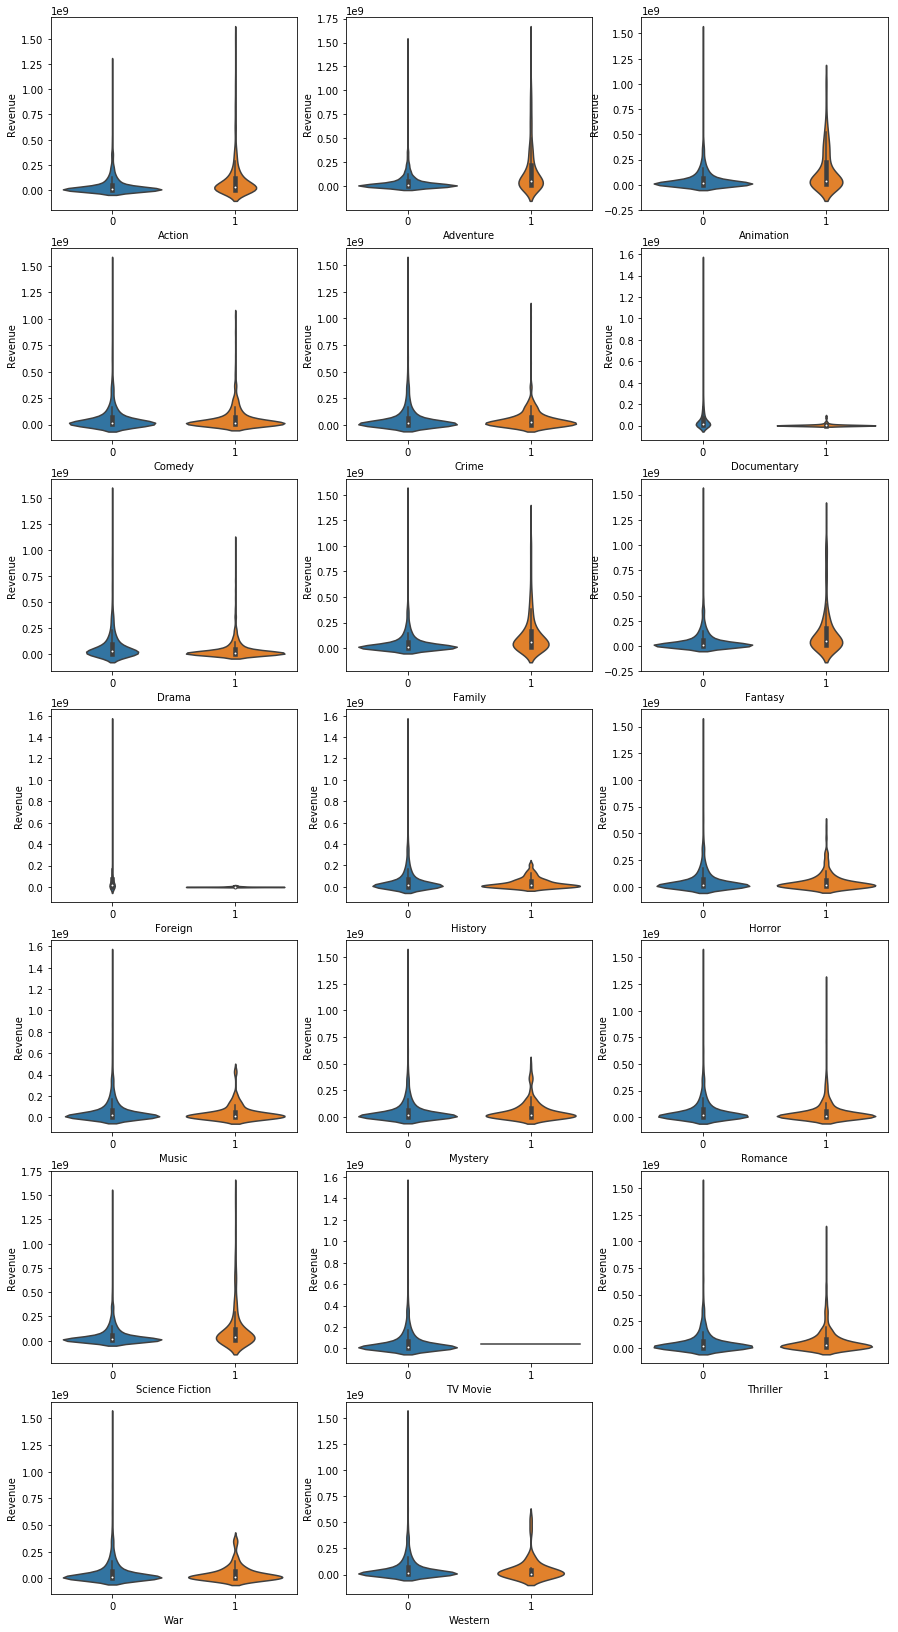

In [15]:
# plot revenue per genre
fig, ax = plt.subplots(7, 3, figsize = [15, 29])
# genre counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 6 and i == 2:
            break
        else:
            ax[j][i] = sb.violinplot(data = train, x = all_genres[counter], y = 'revenue', ax=ax[j][i])
            ax[j][i].set_ylabel('Revenue')
            ax[j][i].set_xlabel(all_genres[counter])
            counter += 1

# deletes the superfluous last empty grid plot
fig.delaxes(ax=ax[6,2]) 
        

From the above plots, we can see that the revenue is different for different genres. I will consider this variable in my later algorithms to predict revenue. Action, Adventure, Animation and Science Fiction in particular have a higher revenue than other genres.

#### belongs_to_collection

In [16]:
# Exploration of collections
analysis(train, 'belongs_to_collection', 25)

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
{}
{}
{}

 [('James Bond Collection', 16), ('Friday the 13th Collection', 7), ('The Pink Panther (Original) Collection', 6), ('Police Academy Collection', 5), ('Pokémon Collection', 5), ('Rocky Collection', 4), ('Ice Age Collection', 4), ('The Fast and the Furious Collection', 4), ('Rambo Collection', 4), ('Alien Collection', 4), ('Resident Evil Collection', 4), ("Child's Play Collection", 4), ('Transformers Collection', 4), ('Paranormal Activity Collection', 4), ('Rush Hour Collection', 3), ('Qatsi Collection', 3), ('The Jaws Collection', 3), ('Diary of a Wimpy Kid Collection', 3), ('Missing in Action Collection', 3), ('Cars Collection', 3), ('Alex Cross Collecti

There are a lot of movies that don't belong to a collection. And most of these collections only contain 3 or 4 movies. Going by the actual collection name may not be useful to predict revenue, but looking at whether a belongs to a collection or not may have an influence on the revenue.

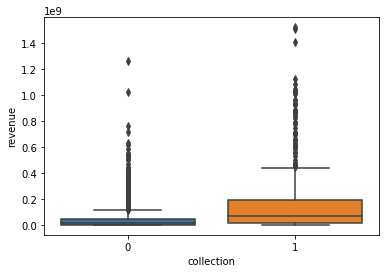

In [17]:
# add column with 1 if movie belongs to any collection and 0 if it does not belong to any collection
train['collection'] = train['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

sb.boxplot(x = 'collection', y = 'revenue', data = train);

In [18]:
print(train.groupby('collection')['revenue'].mean().apply(lambda x: format(x, ',.2f')))


collection
0     43,291,589.83
1    159,686,931.20
Name: revenue, dtype: object


The revenue is generally higher for movies that are part of a collection. I will use this binary collection variable for my algorithm.

#### production_companies

In [19]:
# Exploration of production companies
analysis(train, 'production_companies', 25)


[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
[{'name': 'Walt Disney Pictures', 'id': 2}]
[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
{}
{}

 [('Warner Bros.', 202), ('Universal Pictures', 188), ('Paramount Pictures', 161), ('Twentieth Century Fox Film Corporation', 138), ('Columbia Pictures', 91), ('Metro-Goldwyn-Mayer (MGM)', 84), ('New Line Cinema', 75), ('Touchstone Pictures', 63), ('Walt Disney Pictures', 62), ('Columbia Pictures Corporation', 61), ('TriStar Pictures', 53), ('Relativity Media', 48), ('Canal+', 46), ('United Artists', 44), ('Miramax Films', 40), ('Village Roadshow Pictures', 36), ('Regency Enterprises', 31), ('BBC Films', 30), ('Dune Entertainment', 30), ('Working Title Films', 30), ('Fox Searchlight Pictures', 29), ('StudioCanal', 28), ('Lionsgate', 28), ('DreamWorks SKG', 27), ('Fox 2000 Pictures

Only 156 movies do not have information on their production companies. I would assume that production companies can have an influence on the revenue of the movie (most likely this also has something to do with the average budget that a particular company spends on a movie). 

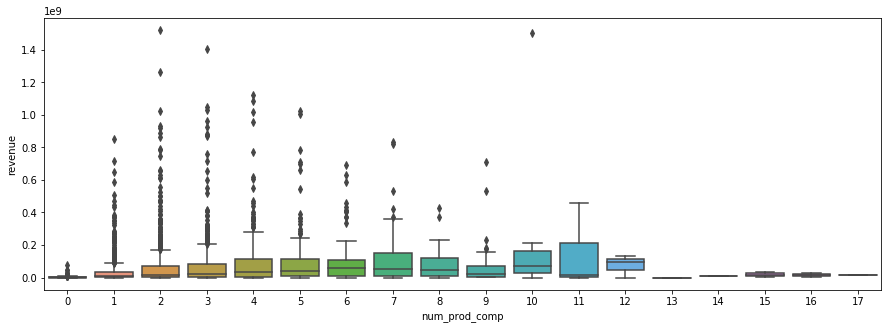

In [20]:
# boxplot showing revenue depending on number of production companies
train['num_prod_comp'] = train['production_companies'].apply(lambda x: len(x))

plt.figure(figsize=[15, 5])
sb.boxplot(x='num_prod_comp', y='revenue', data=train);

In [21]:
# number of different production companies
print('Number of different production companies:', len(all_product_comp))


Number of different production companies: 3695


In [22]:
# Top 15 production companies
counter = 0
top_prod_comps = []
for item in total_count(train, 'production_companies'):
    if counter == 15:
        break
    else:
        header_name = str(item[0])+'_prod'
        train[header_name] = train['production_companies_temp'].apply(lambda x: 1 if item[0] in x else 0)
        top_prod_comps.append(item[0])
    counter += 1


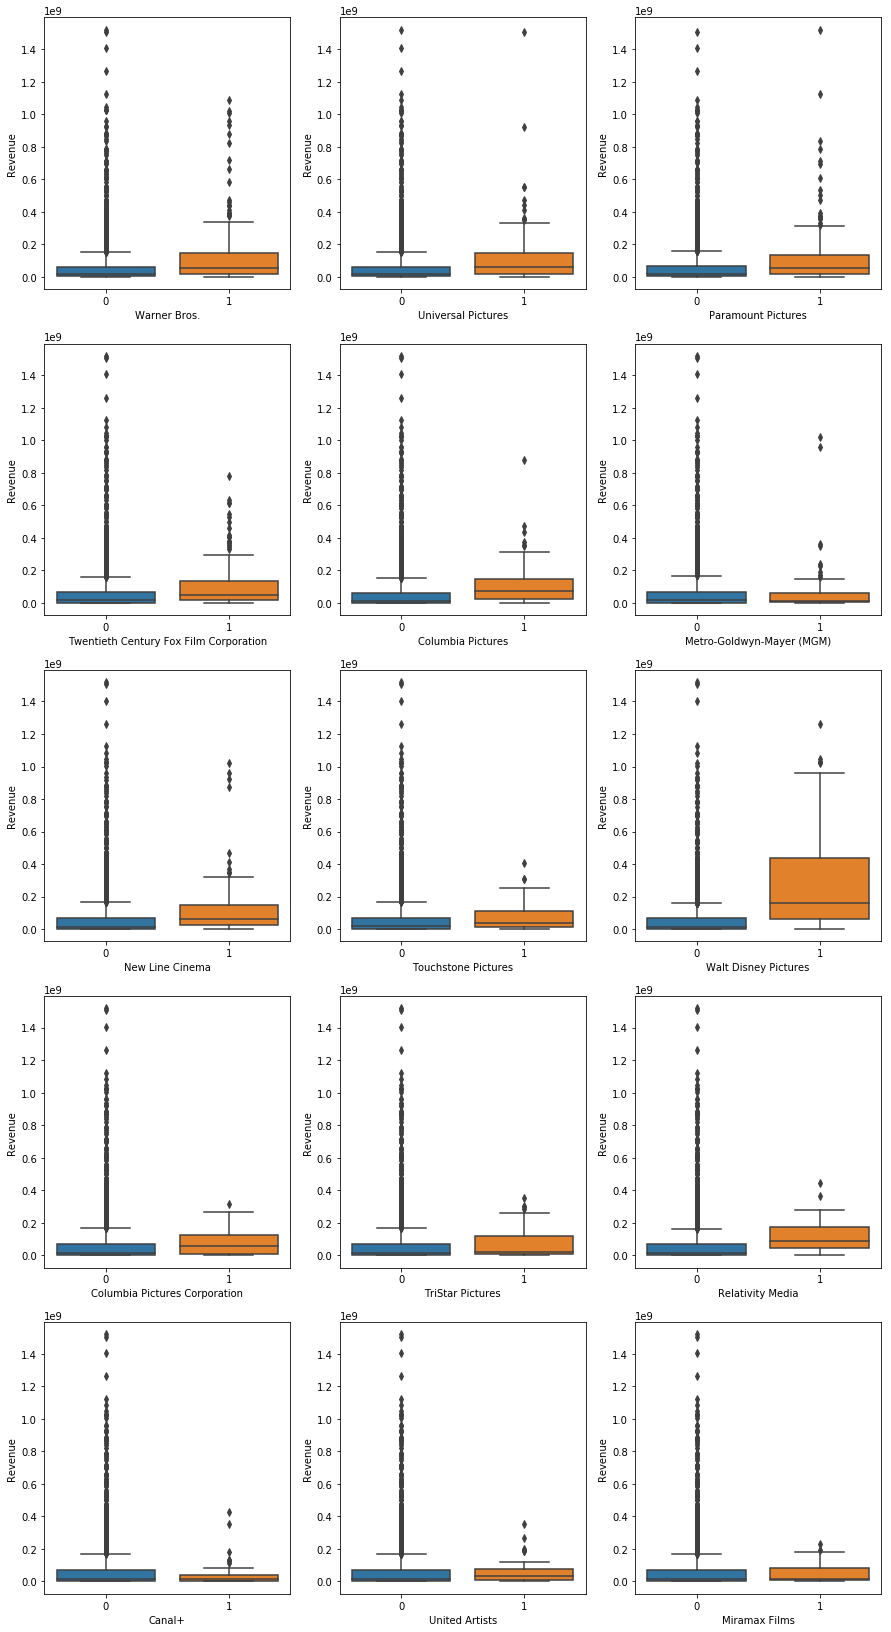

In [23]:
# plotting the revenue of the most common production companies vs. the rest
fig, ax = plt.subplots(5, 3, figsize = [15, 29])
# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 4 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = train, x = top_prod_comps[counter]+'_prod', y = 'revenue', ax=ax[j][i])
            ax[j][i].set_ylabel('Revenue')
            ax[j][i].set_xlabel(top_prod_comps[counter])
            counter += 1
            

In [24]:
# print descriptive statistics of top 15 production companies
prod_headers = [x + '_prod' for x in top_prod_comps]

for comp in prod_headers:
    print(train.groupby(comp)['revenue'].mean().apply(lambda x: format(x, ',.2f')))

Warner Bros._prod
0     62,286,216.47
1    124,816,292.78
Name: revenue, dtype: object
Universal Pictures_prod
0     63,847,576.89
1    109,294,024.26
Name: revenue, dtype: object
Paramount Pictures_prod
0     63,433,421.06
1    124,783,063.90
Name: revenue, dtype: object
Twentieth Century Fox Film Corporation_prod
0     64,448,221.98
1    113,961,915.67
Name: revenue, dtype: object
Columbia Pictures_prod
0     64,816,753.40
1    102,006,983.73
Name: revenue, dtype: object
Metro-Goldwyn-Mayer (MGM)_prod
0    66,668,365.36
1    68,721,455.67
Name: revenue, dtype: object
New Line Cinema_prod
0     64,714,741.00
1    145,159,176.37
Name: revenue, dtype: object
Touchstone Pictures_prod
0    66,515,193.46
1    76,546,547.30
Name: revenue, dtype: object
Walt Disney Pictures_prod
0     61,723,409.31
1    303,777,082.55
Name: revenue, dtype: object
Columbia Pictures Corporation_prod
0    66,535,203.68
1    75,911,345.02
Name: revenue, dtype: object
TriStar Pictures_prod
0    66,516,043.65
1   

As can be seen from the boxplots and the revenue figures above, a majority of the movies that have one or more of the most common production companies in the train data set have a (in the case of Walt Disney significantly) higher average revenue compares to movies without those production companies.

#### production_countries

In [25]:
# Exploration of production countries
analysis(train, 'production_countries', 25)

[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'IN', 'name': 'India'}]
[{'iso_3166_1': 'KR', 'name': 'South Korea'}]

 [('United States of America', 2282), ('United Kingdom', 380), ('France', 222), ('Germany', 167), ('Canada', 120), ('India', 81), ('Italy', 64), ('Japan', 61), ('Australia', 61), ('Russia', 58), ('Spain', 54), ('China', 42), ('Hong Kong', 42), ('Ireland', 23), ('Belgium', 23), ('South Korea', 22), ('Mexico', 19), ('Sweden', 18), ('New Zealand', 17), ('Netherlands', 15), ('Czech Republic', 14), ('Denmark', 13), ('Brazil', 12), ('Luxembourg', 10), ('South Africa', 10)]

 55 data entries without production_countries.


Production countries has only very few missing data points. I may do some correlations between the top 15 countries and revenue later on to see whether there can be seen any connection.

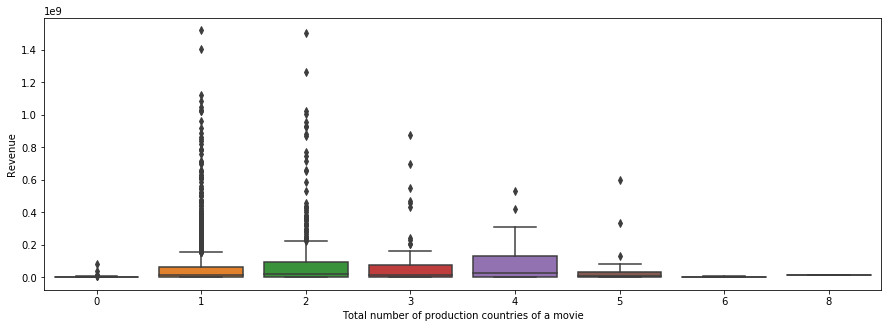

In [26]:
# boxplot showing revenue depending on number of production countries
train['num_prod_coun'] = train['production_countries'].apply(lambda x: len(x))

plt.figure(figsize=[15, 5])
sb.boxplot(x='num_prod_coun', y='revenue', data=train)
plt.xlabel('Total number of production countries of a movie')
plt.ylabel('Revenue');

The median revenue is the highest for movies with 4 production countries

In [27]:
# Top 15 production countries
counter = 0
top_prod_couns = []
for item in total_count(train, 'production_countries'):
    if counter == 15:
        break
    else:
        header_name = str(item[0])+'_prod'
        train[header_name] = train['production_countries_temp'].apply(lambda x: 1 if item[0] in x else 0)
        top_prod_couns.append(item[0])
    counter += 1


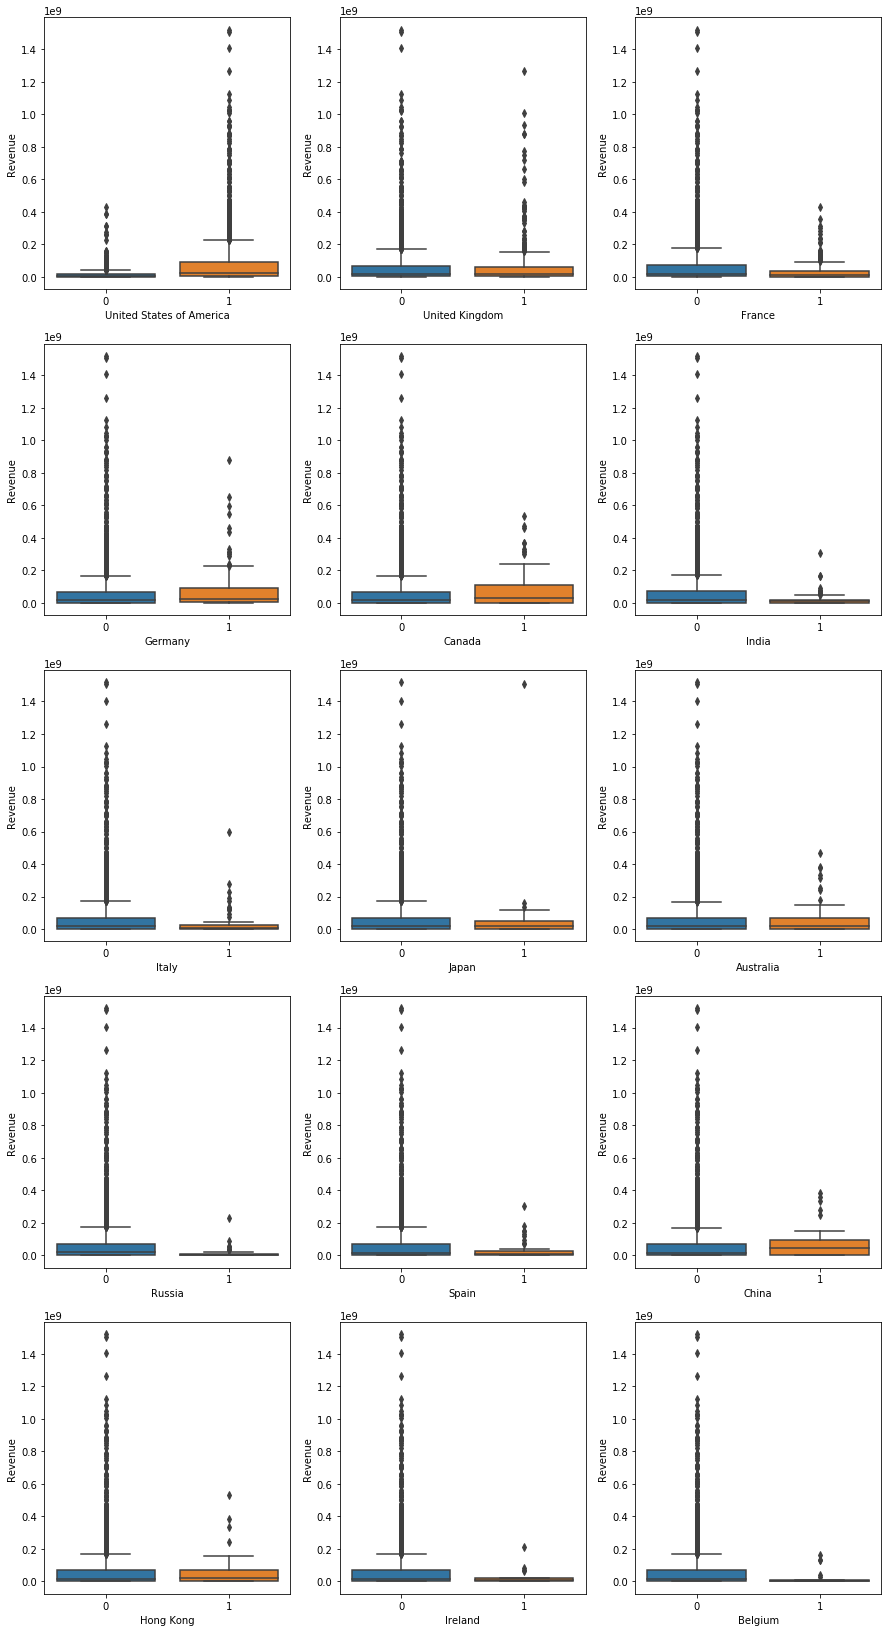

In [28]:
# plotting the revenue of the most common production countries vs. the rest
fig, ax = plt.subplots(5, 3, figsize = [15, 29])
# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 4 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = train, x = top_prod_couns[counter]+'_prod', y = 'revenue', ax=ax[j][i])
            ax[j][i].set_ylabel('Revenue')
            ax[j][i].set_xlabel(top_prod_couns[counter])
            counter += 1

Some of the top 15 most common countries have slightly higher median movie revenues compared to the rest of the the countries. May be worth considering in the algorithm.

#### spoken_languages

In [29]:
# Exploration of spoken languages
analysis(train, 'spoken_languages', 25)

[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}]
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'hi', 'name': 'हिन्दी'}]
[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]

 [('English', 2618), ('Français', 288), ('Español', 239), ('Deutsch', 169), ('Pусский', 152), ('Italiano', 124), ('日本語', 89), ('普通话', 68), ('हिन्दी', 56), ('', 47), ('Português', 43), ('العربية', 40), ('한국어/조선말', 37), ('广州话 / 廣州話', 36), ('தமிழ்', 27), ('Polski', 25), ('Magyar', 24), ('Latin', 23), ('svenska', 22), ('ภาษาไทย', 22), ('Český', 20), ('עִבְרִית', 15), ('ελληνικά', 15), ('Türkçe', 13), ('Dansk', 13)]

 20 data entries without spoken_languages.


I would assume that the spoken language is not going to have much influence on the revenue, since the large majority of films have English as the spoken language.

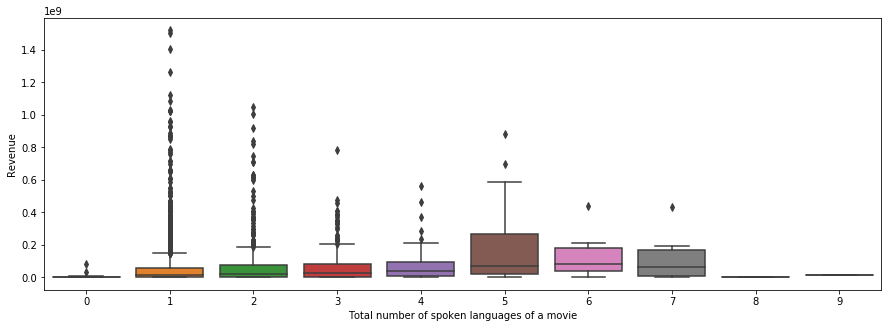

In [30]:
# boxplot showing revenue depending on number of languages
train['num_lang'] = train['spoken_languages'].apply(lambda x: len(x))

plt.figure(figsize=[15, 5])
sb.boxplot(x='num_lang', y='revenue', data=train)
plt.xlabel('Total number of spoken languages of a movie')
plt.ylabel('Revenue');

A movie with 5, 6 or even 7 spoken languages has a higher revenue than other movies. This variable can be included in the algorithm as well.

#### cast

I want to get the top 30 cast members for my algorithm. I am also interested to see whether revenue is correlated with the gender of the cast members.

In [31]:
# Exploration of cast
def analysis_cast_crew(data, header, topk=30):
    for line, value in enumerate(data[header][0][0]):
        print(line, value)

    total = total_count(data, header, topk)
    print('\n', total)

    x = 0
    for row in data[header]:
        if row == {}:
            x += 1

    print('\n', f'{x} data entries without {header}')
    
analysis_cast_crew(train, 'cast', 25)

analysis_cast_crew(test, 'cast', 25)

0 cast_id
1 character
2 credit_id
3 gender
4 id
5 name
6 order
7 profile_path

 [('Samuel L. Jackson', 30), ('Robert De Niro', 30), ('Morgan Freeman', 27), ('J.K. Simmons', 25), ('Bruce Willis', 25), ('Liam Neeson', 25), ('Susan Sarandon', 25), ('Bruce McGill', 24), ('John Turturro', 24), ('Forest Whitaker', 23), ('Willem Dafoe', 23), ('Bill Murray', 22), ('Owen Wilson', 22), ('Nicolas Cage', 22), ('Sylvester Stallone', 21), ('Jason Statham', 21), ('Keith David', 21), ('John Goodman', 21), ('Mel Gibson', 21), ('Sigourney Weaver', 21), ('Frank Welker', 20), ('Michael Caine', 20), ('George Clooney', 20), ('Denzel Washington', 20), ('Robert Duvall', 20)]

 13 data entries without cast
0 cast_id
1 character
2 credit_id
3 gender
4 id
5 name
6 order
7 profile_path

 [('Samuel L. Jackson', 50), ('Robert De Niro', 41), ('Steve Buscemi', 37), ('Bruce Willis', 37), ('Morgan Freeman', 34), ('Robin Williams', 34), ('Sylvester Stallone', 33), ('Johnny Depp', 32), ('Willem Dafoe', 32), ('Julianne Mo

In [32]:
# Top 21 cast members
counter = 0
top_cast = []
for item in total_count(train, 'cast'):
    if counter == 21:
        break
    else:
        header_name = str(item[0])+'_name'
        train[header_name] = train['cast_temp'].apply(lambda x: 1 if item[0] in x else 0)
        top_cast.append(item[0])
    counter += 1


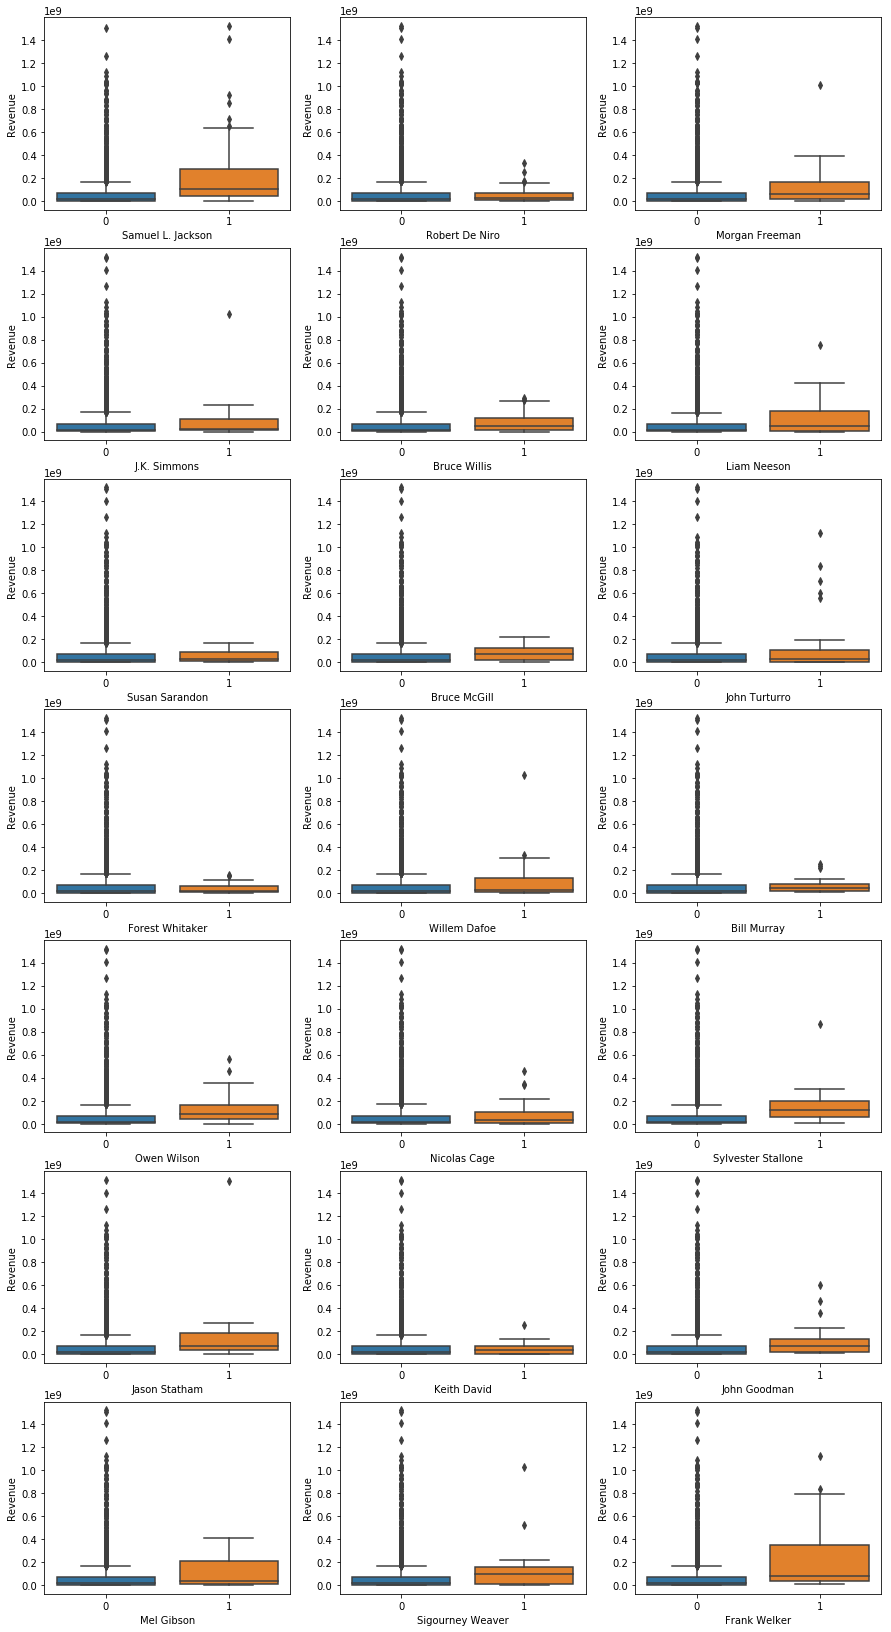

In [33]:
# plotting the revenue of the most common actors vs. the rest
fig, ax = plt.subplots(7, 3, figsize = [15, 29])
# company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 6 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = train, x = top_cast[counter]+'_name', y = 'revenue', ax=ax[j][i])
            ax[j][i].set_ylabel('Revenue')
            ax[j][i].set_xlabel(top_cast[counter])
            counter += 1

Some of these actors and actresses do have higher revenue numbers compared to the movies they were not part of. 

###### gender

In [34]:
# get gender ratio of movies
train['cast_gender'] = train['cast'].apply(lambda x: ','.join([str(i['gender']) for i in x]) if x != {} else '')

train['ratio_gender'] = train['cast_gender'].apply(lambda x: float(format((collections.Counter(x)['1'] + 0.0000001)/(collections.Counter(x)['1'] + 0.0000001 + collections.Counter(x)['2']), ',.2f')))

print(train['ratio_gender'].describe())

count    3000.000000
mean        0.341327
std         0.207959
min         0.000000
25%         0.200000
50%         0.320000
75%         0.450000
max         1.000000
Name: ratio_gender, dtype: float64


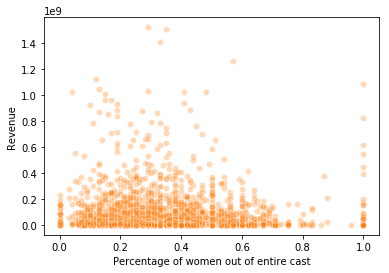

In [35]:
# plotting percentage of women out of entire cast against revenue
sb.scatterplot(train['ratio_gender'], train['revenue'], alpha= 0.3, color=orange)
plt.xlabel('Percentage of women out of entire cast')
plt.ylabel('Revenue');

In [36]:
# correlation between female percentage and revenue
corr_female, p_value = pearsonr(train['ratio_gender'], train['revenue'])
print(corr_female)


-0.03474775873786319


As can be seen in the boxplots for the top 21 cast members, some of the actors and actresses seem to have an effect on the overall revenue on a movie. The female percentage in the cast does not show any correlation with the revenue that is earned by a movie, so this can be disregarded.

It should, however, be noted that I simply disregarded any cast members with the gender value of 0 as this indicates that the gender was not known/added.

What may be interesting to see is whether a woman starring in the leading role will have an effect on the overall revenue of the movie. I will investigate this in the next blocks of code.

In [37]:
# drop all rows with empty dicts or empty lists
train_new = ['cast', 'revenue']
train_cast_rev = train[train_new]

# replace empty dicts and lists with NaN
train_cast_rev['cast'] = train_cast_rev['cast'].apply(lambda x: np.nan if len(x) == 0 else x)

# drop rows with NaNs
train_cast_rev = train_cast_rev.dropna(axis=0, how='any')
train_cast_rev = train_cast_rev.reset_index(drop=True)


C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
# women in lead role
check_gender = lambda x: 0 if x[0]['gender'] == 2 else 1
train_cast_rev['lead_actress'] = train_cast_rev['cast'].apply(check_gender)

# first two leads are women
second_lead_female = lambda x: 0 if len(x) == 1 else(0 if x[1]['gender'] == 2 else 1)
train_cast_rev['second_lead_female'] = train_cast_rev['cast'].apply(second_lead_female)

# first three leads are women
three_lead_female = lambda x: 0 if len(x) < 3 else(0 if x[2]['gender'] == 2 else 1)
train_cast_rev['third_lead_female'] = train_cast_rev['cast'].apply(three_lead_female)


In [39]:
# create a new column with both leads female
train_cast_rev['both_leads_female'] = np.where(train_cast_rev['lead_actress'] + train_cast_rev['second_lead_female'] == 2, 1, 0)                                     

# create a new column with all three leads being female
train_cast_rev['three_leads_female'] = np.where(train_cast_rev['both_leads_female'] + train_cast_rev['third_lead_female'] == 2, 1, 0)


In [40]:
# correlation between lead actress being female and revenue
corr, p = pearsonr(train_cast_rev['lead_actress'], train_cast_rev['revenue'])
print(corr, p)

-0.09404406683155252 2.778699707288062e-07


In [41]:
# correlation between both lead actresses being female and revenue
corr, p = pearsonr(train_cast_rev['both_leads_female'], train_cast_rev['revenue'])
print(corr, p)

-0.09680052402467904 1.2287716693603802e-07


In [42]:
# correlation between all three lead actresses being female and revenue
corr, p = pearsonr(train_cast_rev['three_leads_female'], train_cast_rev['revenue'])
print(corr, p)

-0.08032418904809283 1.1562558426046295e-05


Based on the above assessment, there does not seem to be even a weak correlation between revenue and the movie being led by one, two or three women. So I will disregard this metric in my model later on.

#### crew
Crew members include directors, producers, editors and more. I want to get an overview of all cast members and will plot the top 21 crew members.

In [43]:
# Exploration of crew
analysis_cast_crew(train, 'crew', 25)

0 credit_id
1 department
2 gender
3 id
4 job
5 name
6 profile_path

 [('Avy Kaufman', 50), ('Robert Rodriguez', 44), ('Deborah Aquila', 40), ('James Newton Howard', 39), ('Mary Vernieu', 38), ('Steven Spielberg', 37), ('Luc Besson', 37), ('Jerry Goldsmith', 37), ('Francine Maisler', 35), ('Tricia Wood', 35), ('James Horner', 33), ('Kerry Barden', 32), ('Bob Weinstein', 30), ('Harvey Weinstein', 30), ('Janet Hirshenson', 30), ('Jane Jenkins', 29), ('John Debney', 28), ('Hans Zimmer', 28), ('John Papsidera', 28), ('Francis Ford Coppola', 28), ('Billy Hopkins', 27), ('Danny Elfman', 27), ('Mindy Marin', 27), ('Hans Bjerno', 26), ('Sarah Finn', 26)]

 16 data entries without crew


In [44]:
train['crew'][0][0]

{'credit_id': '59ac067c92514107af02c8c8',
 'department': 'Directing',
 'gender': 0,
 'id': 1449071,
 'job': 'First Assistant Director',
 'name': 'Kelly Cantley',
 'profile_path': None}

In [45]:
# creating temporary dataframe with columns on director names, gender, and producer names and gender
col_crew = ['crew', 'revenue']
train_crew = train[col_crew]

train_crew['director'] = train_crew['crew'].apply(lambda x: ','.join([person['name'] for person in x if person['job'] == 'Director']))
train_crew['producer'] = train_crew['crew'].apply(lambda x: ','.join([person['name'] for person in x if person['job'] == 'Producer']))

train_crew['director_woman'] = train_crew['crew'].apply(lambda x: ','.join([str(person['gender']) for person in x if person['job'] == 'Director']))
train_crew['producer_woman'] = train_crew['crew'].apply(lambda x: ','.join([str(person['gender']) for person in x if person['job'] == 'Producer']))



C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

In [46]:
# Check how many of the directors have a defined gender in the dataset
train_crew.groupby('director_woman').count()


,crew,revenue,director,producer,producer_woman
director_woman,,,,,
,16,16,16,16,16
0,518,518,518,518,518
"0,0",21,21,21,21,21
"0,0,0",1,1,1,1,1
"0,0,0,0,0,0,1",1,1,1,1,1
"0,1",1,1,1,1,1
"0,2",17,17,17,17,17
"0,2,0",1,1,1,1,1
"0,2,0,0,0",1,1,1,1,1


Given who the director or producer of a film is, I'd be interested to see whether there could be any relation. Actually gender might be an interesting additional field to look into in this case, however, 2/3 of the diretors do not have a gender assigned to them in the dataset. Hence, I will disregard gender and only focus on the top names of directors and producers.

In [47]:
train_crew

,crew,revenue,director,producer,director_woman,producer_woman
0,"[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,Steve Pink,Andrew Panay,2,2
1,"[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,Garry Marshall,"Whitney Houston,Mario Iscovich,Debra Martin Chase",2,"1,2,1"
2,"[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,Damien Chazelle,"David Lancaster,Michel Litvak,Jason Blum,Helen...",2,"2,0,2,0"
3,"[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,Sujoy Ghosh,Sujoy Ghosh,0,0
4,"[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,Jong-seok Yoon,,0,
5,"[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638,Hal Sutherland,,2,
6,"[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075,Ole Bornedal,,2,
7,"[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511,Jehane Noujaim,,1,
8,"[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391,Brian Henson,"Frank Oz,Brian Henson",2,"2,2"
9,"[{'credit_id': '52fe45609251416c750545b3', 'de...",18750246,Christopher Guest,Karen Murphy,2,1


In [48]:
# Top 21 crew members
counter = 0
top_crew = []
for person in total_count(train, 'crew'):
    if counter == 21:
        break
    else:
        header_name = str(person[0])+'_name'
        train[header_name] = train['crew_temp'].apply(lambda x: 1 if person[0] in x else 0)
        top_crew.append(person[0])
    counter += 1

top_crew

['Avy Kaufman',
 'Robert Rodriguez',
 'Deborah Aquila',
 'James Newton Howard',
 'Mary Vernieu',
 'Steven Spielberg',
 'Luc Besson',
 'Jerry Goldsmith',
 'Francine Maisler',
 'Tricia Wood',
 'James Horner',
 'Kerry Barden',
 'Bob Weinstein',
 'Harvey Weinstein',
 'Janet Hirshenson',
 'Jane Jenkins',
 'John Debney',
 'Hans Zimmer',
 'John Papsidera',
 'Francis Ford Coppola',
 'Billy Hopkins']

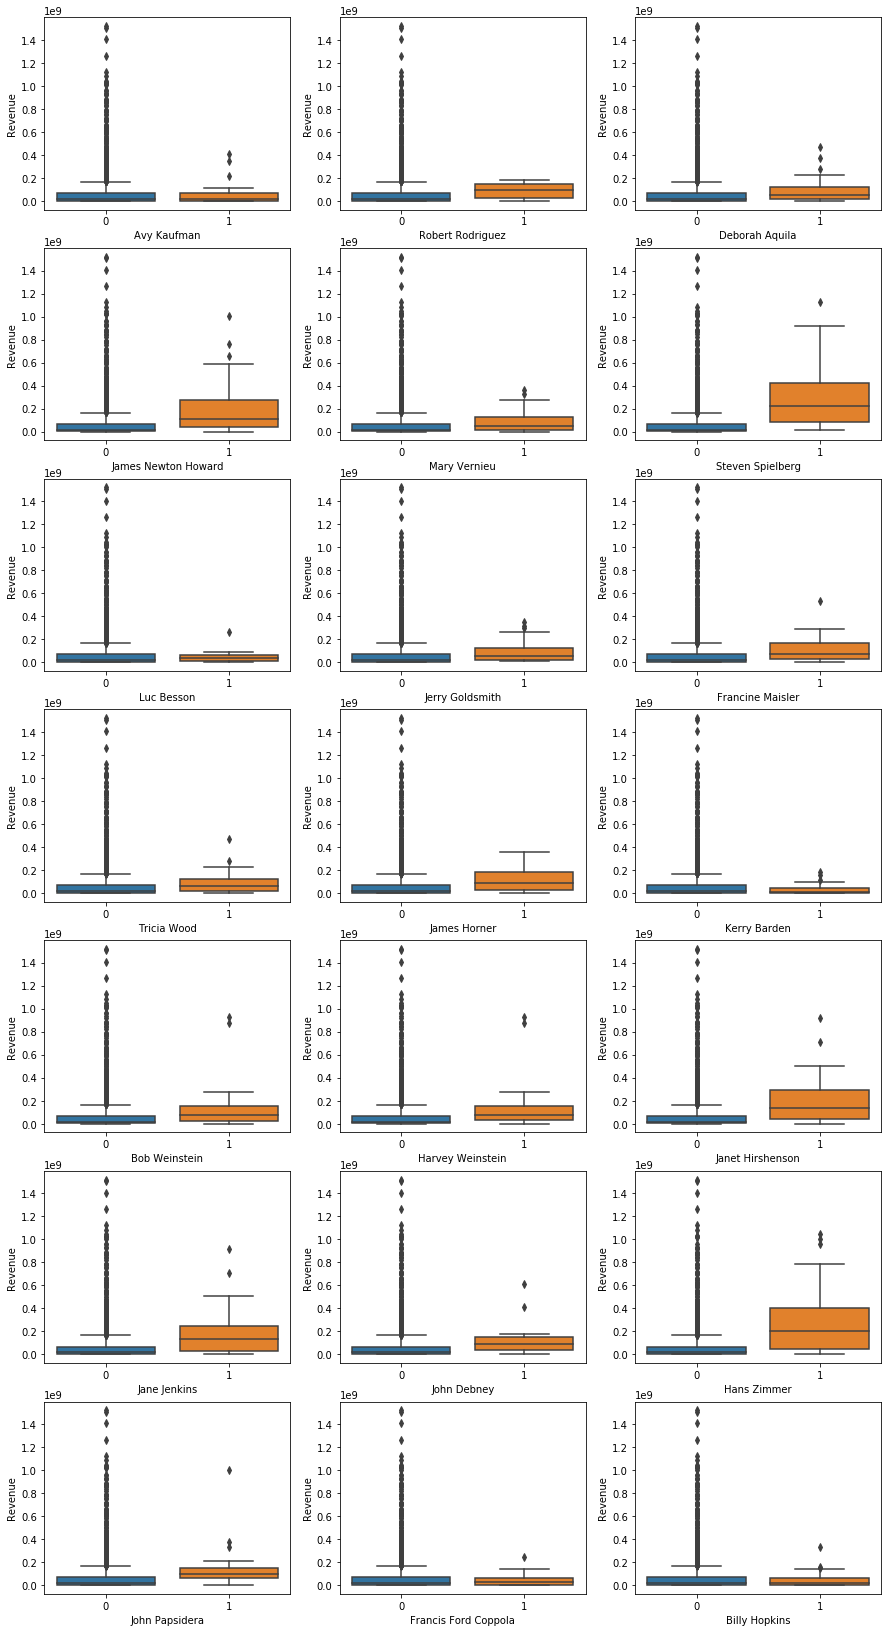

In [49]:
# plotting the revenue of the most common crew members vs. the rest
fig, ax = plt.subplots(7, 3, figsize = [15, 29])
# crew counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 6 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data = train, x = top_crew[counter]+'_name', y = 'revenue', ax=ax[j][i])
            ax[j][i].set_ylabel('Revenue')
            ax[j][i].set_xlabel(top_crew[counter])
            counter += 1
            


I won't distinguish between different crew positions but rather just consider the most common crew members to predict revenue.

#### Keywords

Keywords is actually a very interesting variable which acts as a meta variable that holds information, for example, on the content, genre or gender of directors. I will also boxplot the top 21 keywords.

In [50]:
# Exploration of keywords
analysis(train, 'Keywords', 25)

[{'id': 4379, 'name': 'time travel'}, {'id': 9663, 'name': 'sequel'}, {'id': 11830, 'name': 'hot tub'}, {'id': 179431, 'name': 'duringcreditsstinger'}]
[{'id': 2505, 'name': 'coronation'}, {'id': 4263, 'name': 'duty'}, {'id': 6038, 'name': 'marriage'}, {'id': 13072, 'name': 'falling in love'}]
[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'name': 'obsession'}, {'id': 1640, 'name': 'conservatory'}, {'id': 2176, 'name': 'music teacher'}, {'id': 14512, 'name': 'new york city'}, {'id': 14819, 'name': 'violence'}, {'id': 33896, 'name': 'montage'}, {'id': 156823, 'name': 'drummer'}, {'id': 170418, 'name': 'public humiliation'}, {'id': 176095, 'name': 'jazz band'}, {'id': 206298, 'name': 'young adult'}, {'id': 207739, 'name': 'music school'}]
[{'id': 10092, 'name': 'mystery'}, {'id': 10540, 'name': 'bollywood'}, {'id': 11734, 'name': 'police corruption'}, {'id': 14536, 'name': 'crime'}, {'id': 14636, 'name': 'india'}, {'id': 208364, 'name': 'missing husband'}, {'id': 220935, 'name': 'nerve gas'

In [51]:
# Function to filter out the 21 most common returns of a feature and plot boxplots for each return on revenue
def filter_and_plot(df, value_name):
    '''
    Function to filter out the 21 most common returns of a feature and plot boxplots for each return and 
    its revenue distribution
    Args: df = dataframe
          value_name = lstring; representing the name of the feature to be investigated 
    Returns: top_list = list of 21 most common
    '''
    
    # Top_k values of a feature
    counter = 0
    top_list = []
    for item in total_count(df, value_name):
        if counter == 21:
            break
        else:
            header_name = str(item[0])+'_name'
            df[header_name] = df[value_name+'_temp'].apply(lambda x: 1 if item[0] in x else 0)
            top_list.append(item[0])
        counter += 1
    
    top_list_name = [x+'_name' for x in top_list]
    
    # plotting the revenue of the most common crew members vs. the rest
    fig, ax = plt.subplots(7, 3, figsize = [15, 29])
    # crew counter
    tracker = 0

    for j in range(len(ax)):
        for i in range(len(ax[j])):
            if j == 6 and i == 3:
                break
            else:
                ax[j][i] = sb.boxplot(data = df, x = top_list[tracker]+'_name', y = 'revenue', ax=ax[j][i])
                ax[j][i].set_ylabel('Revenue')
                ax[j][i].set_xlabel(top_list[tracker])
                tracker += 1


    return top_list


['woman director',
 'independent film',
 'duringcreditsstinger',
 'murder',
 'based on novel',
 'violence',
 'sport',
 'biography',
 'aftercreditsstinger',
 'dystopia',
 'revenge',
 'friendship',
 'sex',
 'suspense',
 'sequel',
 'love',
 'police',
 'teenager',
 'nudity',
 'female nudity',
 'drug']

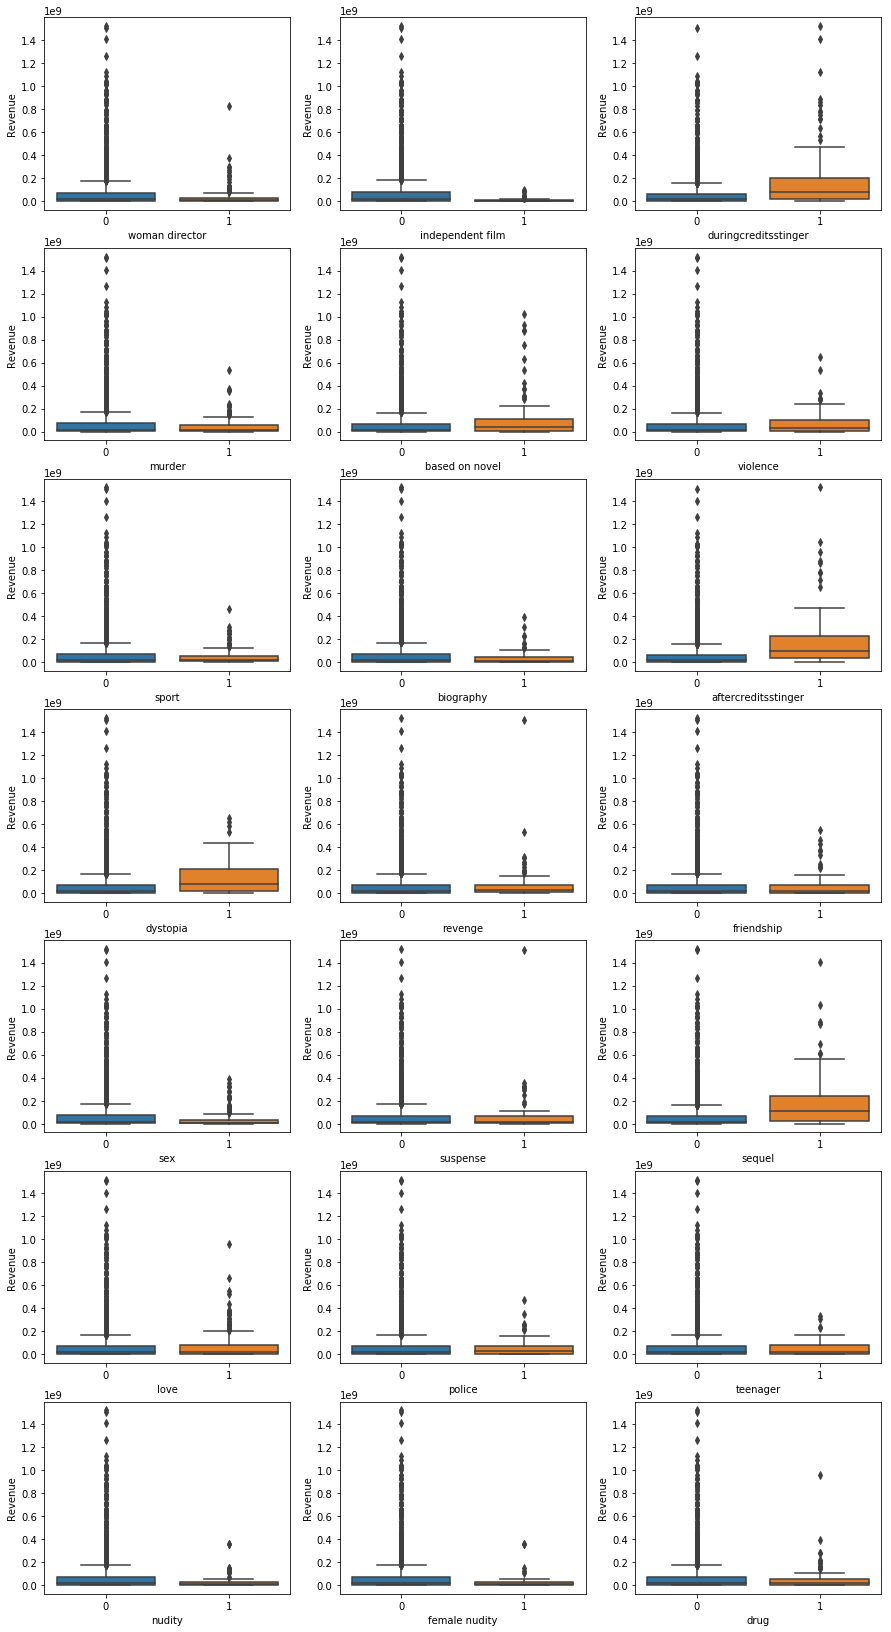

In [52]:
# Get the boxplots of the top 21 keywords and their revenues
top_value = filter_and_plot(train, 'Keywords')
top_value


I could imagine that keywords such as 'sequel', 'based on novel' or 'independent film' could be quite predictive of revenue.

##### Categorical variables

#### homepage

In [53]:
# Exploration of homepage variable
# Get number of NAs
missing_val = train['homepage'].isnull().sum()
print(f'{missing_val} data entries without homepage')


2054 data entries without homepage


I wouldn't know of the top off my head how a homepage could be predictive of the revenue. I'll most likely disregard this variable.

#### poster path
I won't consider the poster path or poster itself in the analysis.

In [54]:
# Exploring the poster path variable
# Get number of NAs
missing_val = train['poster_path'].isnull().sum()
print(f'{missing_val} data entries without poster path')


1 data entries without poster path


#### imdb id
I think this is mainly included in the dataset so that pulling in data from the IMDb API would be easier. For now, I will refrain from doing that and only focus on this existing dataset. There is not need for exploration of this variable.


#### status

In [55]:
# Exploring the status variable
print(train['status'].value_counts(), '\n')
print(test['status'].value_counts())

Released    2996
Rumored        4
Name: status, dtype: int64 

Released           4389
Post Production       5
Rumored               2
Name: status, dtype: int64


The only return that makes sense is released because how would revenue be known if the movie is only rumored? Given that there are only 4 returns in the train dataset with the status 'Rumored', I will drop this feature from the dataset.

#### original language

In [56]:
# Exploration original language
# Get number of NAs
missing_val = train['original_language'].isnull().sum()
print(f'{missing_val} data entries without original language')

train['original_language'] = train['original_language'].fillna('None')
test['original_language'] = test['original_language'].fillna('None')

# Count how many films per language
total_lang = collections.Counter(train['original_language'])
print('\n', total_lang)

0 data entries without original language

 Counter({'en': 2575, 'fr': 78, 'ru': 47, 'es': 43, 'hi': 42, 'ja': 37, 'it': 24, 'ko': 20, 'cn': 20, 'zh': 19, 'de': 18, 'ta': 16, 'sv': 8, 'nl': 6, 'pt': 6, 'fa': 5, 'da': 5, 'ro': 4, 'tr': 3, 'hu': 3, 'te': 2, 'fi': 2, 'no': 2, 'pl': 2, 'ml': 2, 'sr': 1, 'cs': 1, 'mr': 1, 'el': 1, 'ur': 1, 'he': 1, 'ar': 1, 'nb': 1, 'vi': 1, 'bn': 1, 'id': 1})


I won't consider the original language of the movie. The vast majority of the movies have English as the original language.

#### original title
For this variable it may actually be interesting to see how many films are sequels (or prequels). First, I'll extract all titles that have a number in them and then I'll look for similarly titles (e.g. Harry Potter and ...).

0 data entries without original title
188 movies have a title that contains one or more integers


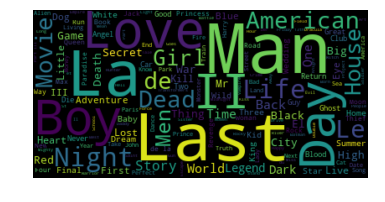

In [57]:
# Exploration original title

# Fill all NAs
missing_val = train['original_title'].isnull().sum()
print(f'{missing_val} data entries without original title')

train['original_title'] = train['original_title'].fillna('None')
test['original_title'] = test['original_title'].fillna('None')

# list all movies that contain numbers
films_with_ints = sorted([title for title in train['original_title'] if re.search(r'\d+', title)])

print(f'{len(films_with_ints)} movies have a title that contains one or more integers')

# create a wordcloud
all_org_title = train['original_title'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_org_title)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [58]:
# print some checks to see how the above words are taken into account
print(all_org_title.count('Life'))

word = [x for x in train['original_title'] if 'Life' in x]

print(word)

21
['Boys Life 2', 'Life During Wartime', 'The Mostly Unfabulous Social Life of Ethan Green', 'The Wild Life', 'This Boy’s Life', 'The Private Life of Sherlock Holmes', 'The Book of Life', 'Life of Crime', 'Life of Brian', 'The Death and Life of Bobby Z', 'A Better Life', 'My Life in Ruins', 'The Life of David Gale', 'The Odd Life of Timothy Green', 'Mishima: A Life in Four Chapters', 'The Life Aquatic with Steve Zissou', 'Life As We Know It', 'The Secret Life of Walter Mitty', 'The Life and Death of 9413, a Hollywood Extra', 'Middle School: The Worst Years of My Life', 'The Tree of Life']


#### overview

8 data entries without overview


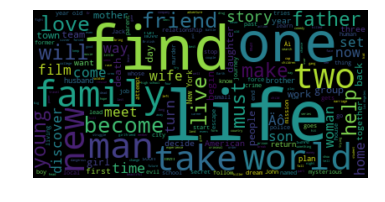

In [59]:
# Explore the overview variable

# Fill all NAs
missing_val = train['overview'].isnull().sum()
print(f'{missing_val} data entries without overview')

train['overview'] = train['overview'].fillna('None')
test['overview'] = test['overview'].fillna('None')

# Creating word cloud
all_overviews = train['overview'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_overviews)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
# check how many times a word above actually appears in the overviews
print(all_overviews.count('family'))


307


I may take the top 10 (?) words of this word cloud and consider these in my algorithm.

#### tagline

597 data entries without tagline


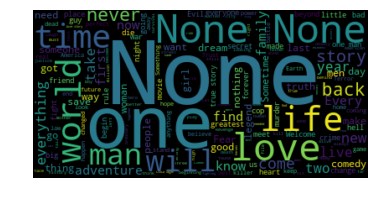

In [61]:
# Explore the tagline variable

# Fill all NAs
missing_val = train['tagline'].isnull().sum()
print(f'{missing_val} data entries without tagline')

train['tagline'] = train['tagline'].fillna('None')
test['tagline'] = test['tagline'].fillna('None')

# Creating word cloud
all_tagline = train['tagline'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_tagline)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

I will use the tagline presence and tagline length to see whether there is any correlation with revenue. This analysis is based on this kernel at kaggle:
https://www.kaggle.com/tavoosi/predicting-box-office-revenue-with-random-forest/report#exploratory-data-analysis

In [62]:
# Add column for existence of tag line
train['tagline_exists'] = train['tagline'].apply(lambda x: 1 if x != 0 else 0)

# Add column for length of tag line
train['tagline'].fillna(0, inplace=True)
train['tagline_length'] = train['tagline'].apply(lambda x: len(x) if x != 0 else 0)



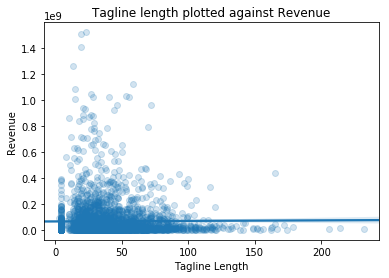

In [63]:
# Plot length of tagline against revenue
sb.regplot(data = train, x='tagline_length', y='revenue', scatter_kws={'alpha': 0.2})
plt.xlabel('Tagline Length')
plt.ylabel('Revenue')
plt.title('Tagline length plotted against Revenue');


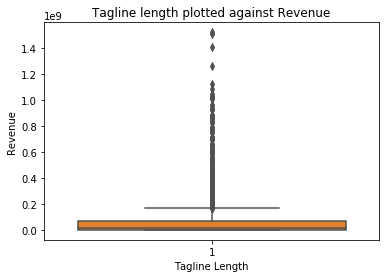

In [64]:
# Add boxplot for revenue per tagline existence option
sb.boxplot(x='tagline_exists', y='revenue', data = train, color = orange)
plt.xlabel('Tagline Length')
plt.ylabel('Revenue')
plt.title('Tagline length plotted against Revenue');


Tagline presence does seem to be related to revenue, while tagline length seems to be irrelevant.

#### title
I will check how big the difference between title and original title is.

In [65]:
# Exploring the title variable
missing_val = train['title'].isnull().sum()
print(f'{missing_val} data entries without title')

train['title'] = train['title'].fillna('None')
test['title'] = test['title'].fillna('None')

v = train['title']
w = train['original_title']

diff_list_title = [{x: y} for x, y in zip(train['title'] , train['original_title']) if x != y]

print(diff_list_title[:5])


0 data entries without title
[{'Marine Boy': '마린보이'}, {'Skinning': 'Šišanje'}, {'The Intouchables': 'Intouchables'}, {'The Double Hour': 'La doppia ora'}, {'Moscow, Belgium': 'Aanrijding in Moscou'}]


There is a difference of ~12% between the title and original title. Since the title is in English, I will only consider this and not the original title.

193 movies have a title that contains one or more integers


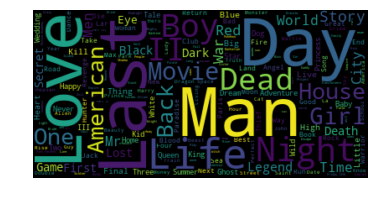

In [66]:
# list all movies that contain numbers
films_with_ints = sorted([title for title in train['title'] if re.search(r'\d+', title)])

print(f'{len(films_with_ints)} movies have a title that contains one or more integers')

# create a wordcloud
all_title = train['title'].str.cat(sep=' ')
wordcloud = WordCloud().generate(all_title)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
# Add column for length of title
train['title'].fillna(0, inplace=True)
train['title_length'] = train['title'].apply(lambda x: len(x) if x != 0 else 0)
train.head()


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,sequel_name,love_name,police_name,teenager_name,nudity_name,female nudity_name,drug_name,tagline_exists,tagline_length,title_length
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,1,0,0,0,0,0,0,1,52,22
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,0,1,0,0,0,0,0,1,60,40
2,3,{},3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,0,0,0,0,0,0,0,1,47,8
3,4,{},1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,0,0,1,0,0,0,0,1,4,7
4,5,{},0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,0,0,0,0,0,0,0,1,4,10


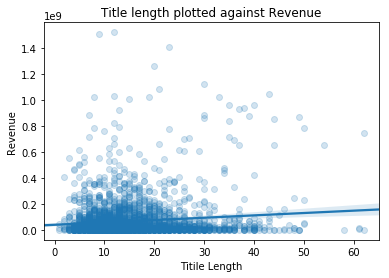

In [68]:
# Plot length of title against revenue
sb.regplot(data = train, x='title_length', y='revenue', scatter_kws={'alpha': 0.2})
plt.xlabel('Titile Length')
plt.ylabel('Revenue')
plt.title('Title length plotted against Revenue');


There seems to be a small effect of title length on revenue.

### Numeric variables


#### budget
I'll now take a look at the numerical features of the dataset. The budget figures are not inflation adjusted.

In [69]:
# descriptive statistics for budget variable
print(train['budget'].describe().apply(lambda x: format(x, 'f')))

# print number of NAs
mis_val = train['budget'].isnull().sum()
print('\n', f'{mis_val} values missing from budget variable')

# print number of zeroes which is equivalent to a missing value
zeroes = [x for x in train['budget'] if x == 0]
print('\n', f'{len(zeroes)} values with the value 0 which is equivalent to a missing value')

trim_10_rev = stats.trim_mean(train['budget'], 0.1)
print('\n', f'The 10% trimmed mean is {trim_10_rev}')


count         3000.000000
mean      22531334.110000
std       37026086.411987
min              0.000000
25%              0.000000
50%        8000000.000000
75%       29000000.000000
max      380000000.000000
Name: budget, dtype: object

 0 values missing from budget variable

 812 values with the value 0 which is equivalent to a missing value

 The 10% trimmed mean is 14133389.000833333


Budget is a very skewed variable. I will apply a log transformation to ease this bias.

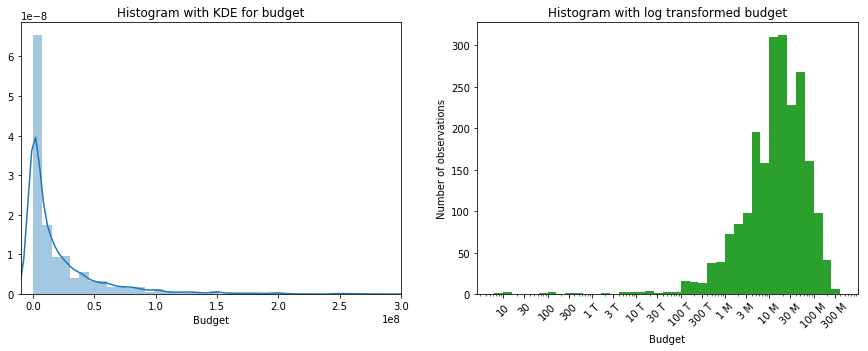

In [70]:
# plotting the budget variable

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
sb.distplot(train['budget'], bins = 50)
plt.xlim(-10000000, 300000000)
plt.xlabel('Budget')
plt.title('Histogram with KDE for budget')

# log transforming the data
plt.subplot(1, 2, 2)
log_data = np.log10(train['budget'] + 1) # add plus 1 to avoid log(0)
plt.xlabel('Budget')
plt.ylabel('Number of observations')
plt.title('Histogram with log transformed budget')
bin_edges = 10 ** np.arange(0.8, np.log10(train['budget'].max()) + 0.2, 0.2)
plt.hist(train['budget'], bins=bin_edges, color = green);
plt.xscale('log')
labels = [10, 30, 100, 300, '1 T', '3 T', '10 T', '30 T', '100 T', '300 T', '1 M', '3 M', '10 M', '30 M', '100 M', '300 M']
tick_locs = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000, 300000000]
plt.xticks(tick_locs, labels, rotation=45);


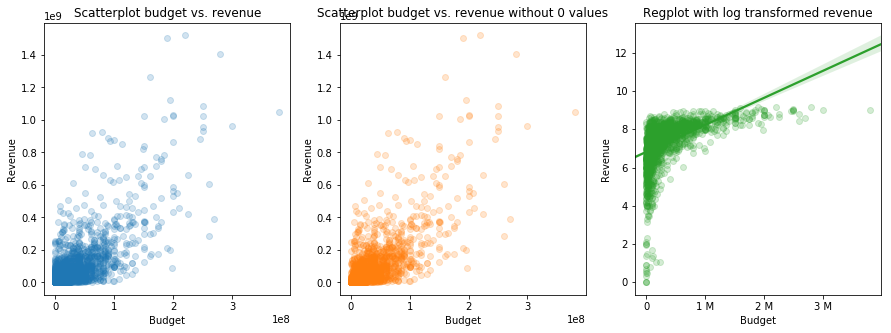

In [71]:
# Scatterplot of budget vs. revenue
fig, axes = plt.subplots(figsize= [15, 5])

plt.subplot(1, 3, 1)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Scatterplot budget vs. revenue')
plt.scatter(data = train, x='budget', y='revenue', alpha = 0.2);

# drop all rows with zeros
train_new = ['budget', 'revenue']
placeholder = train[train_new]
placeholder = placeholder.loc[~(placeholder==0).any(axis=1)]

# scatterplot without the NA/zero values in budget variable
plt.subplot(1, 3, 2)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Scatterplot budget vs. revenue without 0 values')
plt.scatter(placeholder['budget'], placeholder['revenue'], alpha = 0.2, color = orange);

# regplot with log transformation
plt.subplot(1, 3, 3)
sb.regplot(placeholder['budget'], placeholder['revenue'].apply(lambda x: np.log10(x)), scatter_kws={'alpha': 0.2}, color = green);
ax = plt.gca()
ax.set_xticklabels(['0', '0', '1 M', '2 M', '3 M'])
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Regplot with log transformed revenue');



There was only a mild improvement in the scatterplot of budget vs. revenue after removing all rows with values of 0. During the feature transformation section, I will exclude all rows that do not have a budget value. Looking at the regplot with a log transformed revenue (which I applied because the distribution of points appeared to be in the form of log(y) &alpha;	x), there seems to be a moderate non-linear relationship between these two variables.

I think it may be important to attribute the budget to the release year of the movie since spending USD 1 billion in 1990 was different than in 2018. I will calculate a budget-year-ratio further below after engineering the release date feature.

#### revenue
The revenue figures are not adjusted for inflation, so I am expecting the revenue figures to continuously increase over the years just because of the increase of ticket prices. It is rather difficult to properly adjust revenue for inflation. First of all, ticket prices increased at a different pace than overall inflation. Moreover, there are many instances where a movie was re-released over time, so ticket prices would need to be used to calculate the number of tickets sold at those particular re-release years. It gets messy fairly quickly. I will therefore stick to the unadjusted numbers, the same way I am keeping the budget unadjusted as well.

In [72]:
# get descriptive statistics for revenue variable
print(train['revenue'].describe().apply(lambda x: format(x, 'f')))
mis_val_rev = train['revenue'].isnull().sum().sum()
print('\n', f'{mis_val_rev} entries NA')

trim_10_rev = stats.trim_mean(tuple(train['revenue']), 0.1) # tuple declaration is necessary to avoid warning message
print('\n', f'The 10% trimmed mean is {trim_10_rev}')

count          3000.000000
mean       66725851.888667
std       137532326.336018
min               1.000000
25%         2379808.250000
50%        16807068.000000
75%        68919203.500000
max      1519557910.000000
Name: revenue, dtype: object

 0 entries NA

 The 10% trimmed mean is 35059391.91083334


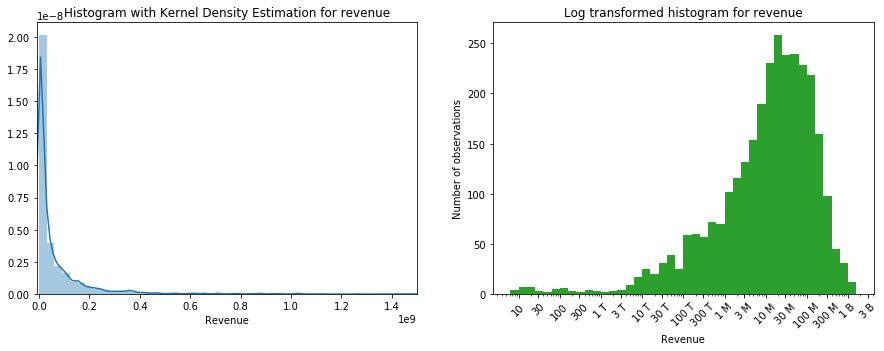

In [73]:
# plotting the revenue variable

plt.figure(figsize=[15, 5])
plt.subplot(1, 2, 1)
sb.distplot(train['revenue'], bins = 50)
plt.xlim(-10000000, 1500000000)
plt.xlabel('Revenue')
plt.title('Histogram with Kernel Density Estimation for revenue')

# log transforming the data
plt.subplot(1, 2, 2)
log_data = np.log10(train['revenue'] + 1) # add plus 1 to avoid log(0)
plt.xlabel('Revenue')
plt.ylabel('Number of observations')
plt.title('Log transformed histogram for revenue')
bin_edges = 10 ** np.arange(0.8, np.log10(train['revenue'].max()) + 0.2, 0.2)
plt.hist(train['revenue'], bins=bin_edges, color = green);
plt.xscale('log')
labels = [10, 30, 100, 300, '1 T', '3 T', '10 T', '30 T', '100 T', '300 T', '1 M', '3 M', '10 M', '30 M', '100 M', '300 M', '1 B', '3 B']
tick_locs = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000, 300000000, 1000000000, 3000000000]
plt.xticks(tick_locs, labels, rotation=45);


#### popularity

In [74]:
# get descriptive statistics for popularity variable
print(train['popularity'].describe().apply(lambda x: format(x, 'f')))
mis_val_rev = train['popularity'].isnull().sum().sum()
print('\n', f'{mis_val_rev} entries NA')

# print number entries with a value of less than 1
zeroes = [x for x in train['popularity'] if x < 1]
print('\n', f'{len(zeroes)} values that are smaller than 1.', '\n')

# print the ten most popular movies in the train dataset
pop_train = [{x: y} for x, y in zip(train['popularity'] , train['title']) if x > 100]
pop_train_s = sorted(pop_train, key=lambda x: list(x.keys()))[:10]
print(f'Most popular movies in train dataset: {pop_train_s}', '\n')

# print the ten most popular movies in the test dataset
pop_test = [{v: w} for v, w in zip(test['popularity'] , test['title']) if v > 100]
pop_test_s = sorted(pop_test, key=lambda y: list(y.keys()))[:10]
print(f'Most popular movies in test dataset: {pop_test_s}')


count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: object

 0 entries NA

 235 values that are smaller than 1. 

Most popular movies in train dataset: [{123.167259: 'The Dark Knight'}, {146.161786: 'War for the Planet of the Apes'}, {154.80100900000002: 'Gone Girl'}, {185.33099199999998: 'Guardians of the Galaxy Vol. 2'}, {187.860492: 'Deadpool'}, {228.032744: 'Baby Driver'}, {287.253654: 'Beauty and the Beast'}, {294.337037: 'Wonder Woman'}] 

Most popular movies in test dataset: [{133.82782: 'Pirates of the Caribbean: Dead Men Tell No Tales'}, {140.95023600000002: 'Pulp Fiction'}, {145.882135: 'Captain America: Civil War'}, {147.098006: 'The Hunger Games: Mockingjay - Part 1'}, {183.870374: 'John Wick'}, {185.070892: 'Avatar'}, {213.84990699999997: 'Big Hero 6'}, {547.4882980000001: 'Minions'}]


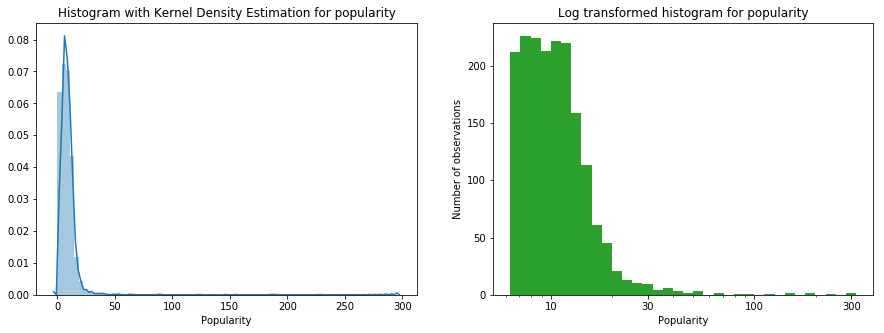

In [75]:
# visual exploration of the popularity variable

# distplot of popularity
plt.figure(figsize = [15, 5])
plt.subplot(1, 2, 1)
sb.distplot(train['popularity'], bins = 80)
plt.xlabel('Popularity')
plt.title('Histogram with Kernel Density Estimation for popularity')

# log transformed histogram
plt.subplot(1, 2, 2)
log_data = np.log10(tuple(train['popularity'] + 1)) # add plus 1 to avoid log(0) and put it into tuple to avoid warning
plt.xlabel('Popularity')
plt.ylabel('Number of observations')
plt.title('Log transformed histogram for popularity')
bin_edges = 10 ** np.arange(0.8, np.log10(train['popularity'].max()) + 0.05, 0.05)
plt.hist(train['popularity'], bins=bin_edges, color = green);
plt.xscale('log')
tick_locs = [10, 30, 100, 300]
plt.xticks(tick_locs, tick_locs,);


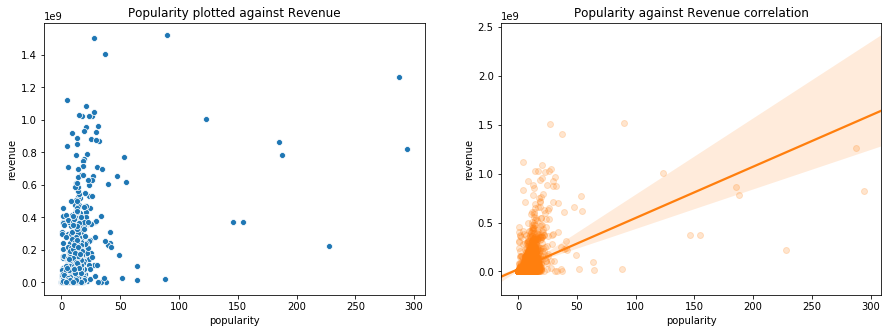

In [76]:
# scatterplot of popularity vs. revenue
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Popularity plotted against Revenue')
sb.scatterplot(data = train, x='popularity', y='revenue')

plt.subplot(1, 2, 2)
plt.xlabel('Popularity')
plt.ylabel('Revenue')
plt.title('Popularity against Revenue correlation')
sb.regplot(data = train, x='popularity', y='revenue', color = orange, scatter_kws = {'alpha': 0.2});


I actually expected this metric to be similar to a star rating from 1 to 10. However, according to the movie databases [API docs](https://developers.themoviedb.org/3/getting-started/popularity), it is based on a number of different metrics, including number of votes and views for a day. Moreover, according to a [moderator at the TMDB website](https://www.themoviedb.org/talk/5141d424760ee34da71431b0), the lower bound of this value is 0 and the upper bound is technically infinity. The higher the value (and in this sense, it is a ranking), the more popular a title is. For example, the most popular movie title in the train dataset is Wonder Woman. Given the above plots, surprisingly, there seems to be a low correlation between the popularity variable of a movie and the revenue it generates.

#### release date

In [77]:
# get descriptive statistics for release date variable
print(train['release_date'].describe())
mis_val_rev = train['release_date'].isnull().sum().sum()
print('\n', f'{mis_val_rev} entries NA', '\n')

# create new dataframe columns containing only the year and only the month of release
temp_col = ['release_date', 'revenue', 'title']
temp = pd.DataFrame(train[temp_col])

temp['release_year'] = train['release_date'].map(lambda x: str(19) + x[-2:] if int(x[-2:]) > 17 else str(20) + x[-2:])
temp['release_month'] = train['release_date'].map(lambda x: int(x[:2]) if x[1] != '/' else int(x[:1]))

print(temp.head())

count        3000
unique       2398
top       9/10/15
freq            5
Name: release_date, dtype: object

 0 entries NA 

  release_date   revenue                                     title  \
0      2/20/15  12314651                    Hot Tub Time Machine 2   
1       8/6/04  95149435  The Princess Diaries 2: Royal Engagement   
2     10/10/14  13092000                                  Whiplash   
3       3/9/12  16000000                                   Kahaani   
4       2/5/09   3923970                                Marine Boy   

  release_year  release_month  
0         2015              2  
1         2004              8  
2         2014             10  
3         2012              3  
4         2009              2  


The raw release_date data in the train and test files only contain a shortened year format such as '17' or '87'. There is a gap in the years between the years 17 and 21. In order to ensure that 17 actually refers to 2017, I am printing out the movies released in 2017 to do a quick check if they actually were released then (and not in 1917).

In [78]:
# print the movies that were released in '17 to check whether this year relates to 2017 or 1917

seventeen = [x for x, y in zip(temp['title'], temp['release_year']) if int(y) == 2017]

print(seventeen)

['Wilson', "The Zookeeper's Wife", 'Cars 3', 'Chasing Trane', 'The Spacewalker', 'Phoenix Forgotten', "A Dog's Purpose", 'Wonder Woman', 'Unforgettable', 'Sahara', 'Beauty and the Beast', 'Table 19', 'John Wick: Chapter 2', 'Snatched', 'Bairavaa', 'Power Rangers', '2:22', 'Lady Macbeth', 'Song to Song', 'Rescue Under Fire', 'Lovesong', 'The Hero', 'The Ottoman Lieutenant', 'Transformers: The Last Knight', 'Baby Driver', 'War for the Planet of the Apes', 'Black Snow', 'Logan', 'The Mummy', 'Guardians of the Galaxy Vol. 2', 'The Circle', 'Diary of a Wimpy Kid: The Long Haul', 'Their Finest', 'Valerian and the City of a Thousand Planets', 'Get Out', 'The Boss Baby', 'The Wall', 'The Beguiled', 'Rings', 'The Shack']


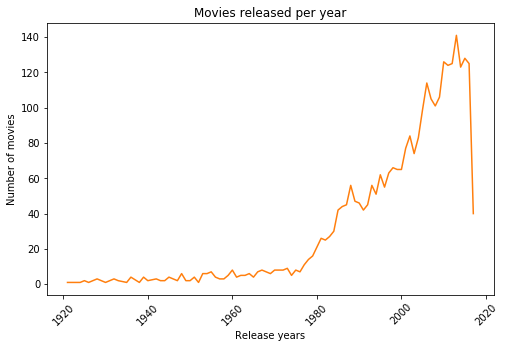

In [79]:
# number of films per year

plt.figure(figsize = [8, 5])

acc_year = temp['release_year'].value_counts().sort_index()

acc_year.index = acc_year.index.values.astype(int)

plt.plot(acc_year.index, acc_year.values, color = orange);
plt.xlabel('Release years')
plt.ylabel('Number of movies')
plt.title('Movies released per year')
plt.xticks(rotation=45);

plt.locator_params(axis='x', nbins=7)

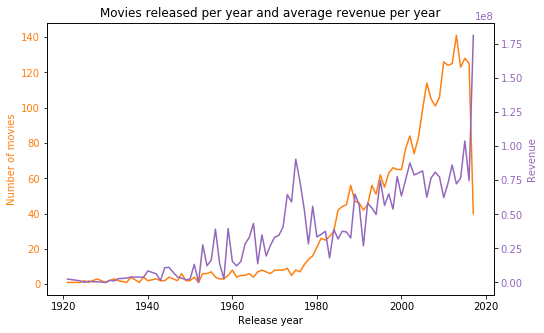

In [80]:
# number of movies released per year and the average revenue per year

fig, ax1 = plt.subplots(figsize = [8, 5])

acc_year = temp['release_year'].value_counts().sort_index()
avg_rev = temp.groupby(['release_year'])['revenue'].mean()

acc_year.index = acc_year.index.values.astype(int)

ax1.plot(acc_year.index, acc_year.values, color = orange)
ax1.set_xlabel('Release year')
ax1.set_ylabel('Number of movies', color = orange)
ax1.tick_params(axis='y', labelcolor = orange)
plt.title('Movies released per year and average revenue per year')

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
# using d1.index as the x values, just like for the y-axis on the left
ax2.plot(acc_year.index, avg_rev.values, color = purple)
ax2.set_ylabel('Revenue', color = purple)
ax2.tick_params(axis='y', labelcolor = purple)


As mentioned before, the revenue and budget figures are not inflation adjusted in this dataset. Because of this large spike of average revenue per film in the 1970s, I want to check whether there is actually some bad data in this data set (namely an inflation adusted revenue figure), so I will take a look at the particular films that were released that year and cross check the numbers with the data from the Box Office Mojo site, which provides inflation adjusted revenue numbers.

In [81]:
# create new dataframe containing accumulated figures
column_corr = ['release_year', 'movies_year', 'avg_rev_year']

corr = pd.DataFrame(columns = [column_corr])

corr['release_year'] = sorted(set(temp['release_year']))
corr['movies_year'] = acc_year.values
corr['avg_rev_year'] = avg_rev.values

print(corr.head())

  release_year movies_year avg_rev_year
0         1921           1    2500000.0
1         1924           1    1213880.0
2         1925           2      22550.5
3         1926           1     966878.0
4         1927           2     513939.0


In [82]:
# print if movies were release in certain year

top_gross_mov = [{y['release_year'][0]: '{0:,.2f}'.format(y['avg_rev_year'][0])} for x, y in corr.iterrows() if float(y['avg_rev_year']) > 80000000]
print(top_gross_mov, '\n')

movies_1975 = [{y['title']: '{0:,}'.format(y['revenue'])} for x, y in temp.iterrows() if float(y['release_year']) == 1975]
print(movies_1975)

[{'1975': '90,480,379.50'}, {'2002': '87,773,835.64'}, {'2004': '80,308,074.69'}, {'2005': '81,908,092.21'}, {'2008': '80,945,077.79'}, {'2012': '86,166,013.78'}, {'2015': '103,854,185.98'}, {'2017': '181,403,935.10'}] 

[{'The Return of the Pink Panther': '41,833,347'}, {'Jaws': '470,654,000'}, {'Cry, Onion!': '39,598,448'}, {'Rooster Cogburn': '8,022,000'}, {'Breakout': '16,000,000'}, {'The Great Waldo Pepper': '20,642,922'}, {'The Rocky Horror Picture Show': '112,892,319'}, {'The Eiger Sanction': '14,200,000'}]


By manual comparison (for now), the numbers of these movies in 1975 are not inflation adjusted. The big outlier is Jaws with USD470 million but this is indeed the unadjusted gross figure. I will now take a look at the correlation between release month and the revenue.

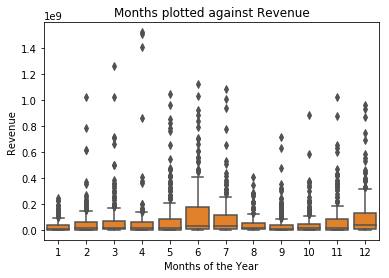

In [83]:
sb.boxplot(x='release_month', y='revenue', data = temp, color = orange)
plt.xlabel('Months of the Year')
plt.ylabel('Revenue')
plt.title('Months plotted against Revenue');

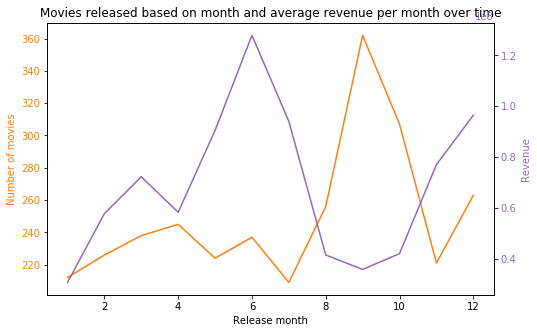

In [84]:
# revenue by month of year
fig, ax1 = plt.subplots(figsize = [8, 5])

acc_month = temp['release_month'].value_counts().sort_index()
avg_rev_month = temp.groupby(['release_month'])['revenue'].mean()

acc_month.index = acc_month.index.values.astype(int)

ax1.plot(acc_month.index, acc_month.values, color = orange)
ax1.set_xlabel('Release month')
ax1.set_ylabel('Number of movies', color = orange)
ax1.tick_params(axis='y', labelcolor = orange)
plt.title('Movies released based on month and average revenue per month over time')

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
# using d1.index as the x values, just like for the y-axis on the left
ax2.plot(acc_month.index, avg_rev_month.values, color = purple)
ax2.set_ylabel('Revenue', color = purple)
ax2.tick_params(axis='y', labelcolor = purple)

While the most movies are released in September and October, the highest average revenue is generated in June, July, and December. The boxplot above shows that the highest grossing movies were actually released in April. Based on the above plots, the release month may be predictive of revenue.

In [85]:
# Add release week
temp['release_week'] = temp['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').isocalendar()[1])
# Add weekday
temp['release_weekday'] = temp['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').strftime('%A'))
temp.head()


,release_date,revenue,title,release_year,release_month,release_week,release_weekday
0,2/20/15,12314651,Hot Tub Time Machine 2,2015,2,8,Friday
1,8/6/04,95149435,The Princess Diaries 2: Royal Engagement,2004,8,32,Friday
2,10/10/14,13092000,Whiplash,2014,10,41,Friday
3,3/9/12,16000000,Kahaani,2012,3,10,Friday
4,2/5/09,3923970,Marine Boy,2009,2,6,Thursday


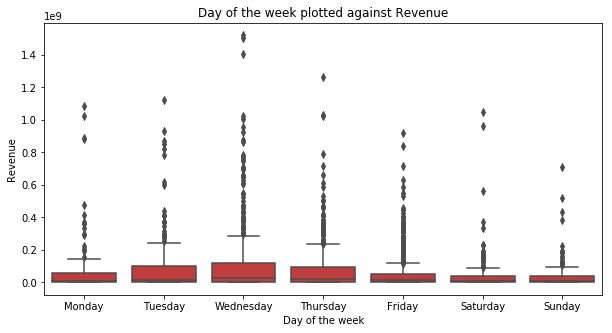

In [86]:
# Create boxplot for revenue by weekday
plt.figure(figsize = [10, 5])
sb.boxplot(x='release_weekday', y='revenue', data = temp, color = red, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Day of the week')
plt.ylabel('Revenue')
plt.title('Day of the week plotted against Revenue');


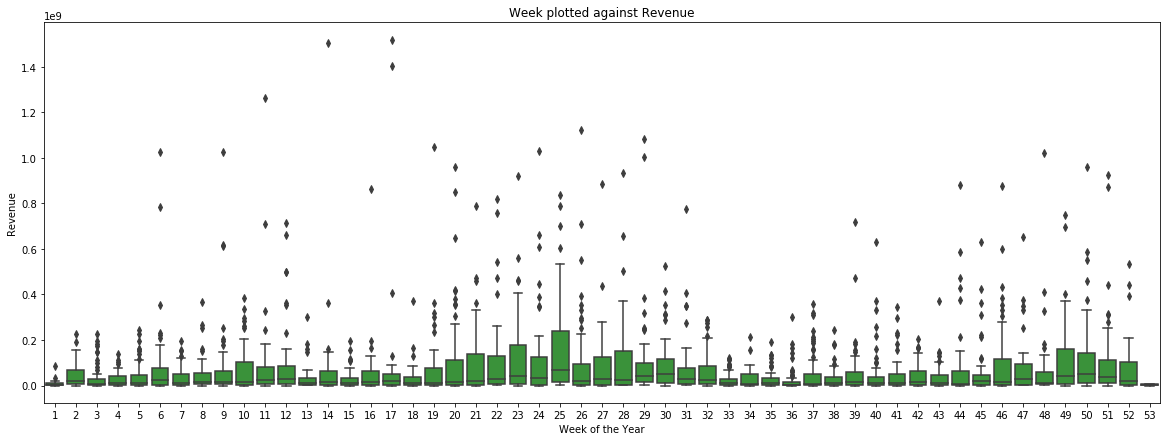

In [87]:
# Create boxplot for revenue per week
plt.figure(figsize = [20, 7])
sb.boxplot(x='release_week', y='revenue', data = temp, color = green)
plt.xlabel('Week of the Year')
plt.ylabel('Revenue')
plt.title('Week plotted against Revenue');


Generally, movies released during summer and before Christmas have higher median revenues than movies released during other times of the year.

##### Budget-year-ratio



In [88]:
# Add budget column to temp dataframe
temp = temp.join(train['budget'])

# Add new column budget_year_column
temp['release_year'] = temp['release_year'].astype('int32')
temp['budget_year_ratio'] = round(temp['budget']/temp['release_year'], 2)
temp


,release_date,revenue,title,release_year,release_month,release_week,release_weekday,budget,budget_year_ratio
0,2/20/15,12314651,Hot Tub Time Machine 2,2015,2,8,Friday,14000000,6947.89
1,8/6/04,95149435,The Princess Diaries 2: Royal Engagement,2004,8,32,Friday,40000000,19960.08
2,10/10/14,13092000,Whiplash,2014,10,41,Friday,3300000,1638.53
3,3/9/12,16000000,Kahaani,2012,3,10,Friday,1200000,596.42
4,2/5/09,3923970,Marine Boy,2009,2,6,Thursday,0,0.00
5,8/6/87,3261638,Pinocchio and the Emperor of the Night,1987,8,32,Thursday,8000000,4026.17
6,8/30/12,85446075,The Possession,2012,8,35,Thursday,14000000,6958.25
7,1/15/04,2586511,Control Room,2004,1,3,Thursday,0,0.00
8,2/16/96,34327391,Muppet Treasure Island,1996,2,7,Friday,0,0.00
9,4/16/03,18750246,A Mighty Wind,2003,4,16,Wednesday,6000000,2995.51


#### runtime

In [89]:
# get descriptive statistics for runtime variable
print(train['runtime'].describe())
mis_val_run = train['runtime'].isnull().sum().sum()
print('\n', f'{mis_val_run} entries NA', '\n')

# fill all NAs with 0s
train['runtime'] = train['runtime'].fillna(0);


count    2998.000000
mean      107.856571
std        22.086434
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64

 2 entries NA 



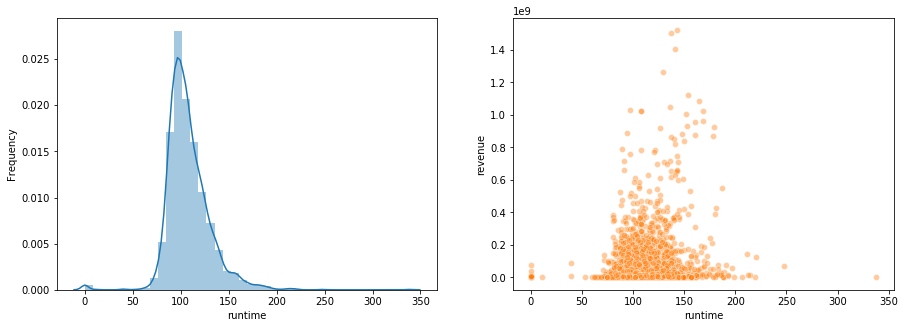

In [90]:
plt.figure(figsize = [15, 5])

plt.subplot(1, 2, 1)
plt.xlabel('Runtime of a movie')
plt.ylabel('Frequency')
sb.distplot(train['runtime'], bins=40);

plt.subplot(1, 2, 2)
sb.scatterplot(data = train, x='runtime', y='revenue', color = orange, alpha=0.4)


In [91]:
correl, p_value = pearsonr(train['runtime'], train['revenue'])

print(correl, p)

0.2162299348350639 1.1562558426046295e-05


The correlation between runtime and revenue is fairly low. It does not seem that runtime is particularly predictive of revenue.

### 3. Data Preparation

In the sections below, I will clean and transform all variables I want to consider for the prediction of revenue.


#### 3.1. Feature cleaning and engineering

I have used the cleaning steps from above to create a clean function that I can apply to both the train and test datasets. After the dataframes have been read in and cleaned, any relevant numeric variables will be log transformed and all variables will then be scaled.

In [92]:
def len_var(df, col):
    '''
    Function to create new column containing number of values 
    in respective row of specified column
    Args: df = dataframe
          col = str; column header
    Returns: df = dataframe
    '''
    df['number_'+col] = df[col].apply(lambda x: len(x))

    return df


def add_top_30(dataset, col, topk):
    '''
    Function to add top 30 results from column headers as separate columns to 
    dataframe
    Args: dataset = dataframe 
          col = string; column name
          topk = list; top k values in column
    Returns: dataset = dataframe
    '''
    counter = 0
    for item in topk:
        header_name = str(item[0])+'_name'
        dataset[header_name] = dataset[col+'_temp'].apply(lambda x: 1 if item[0] in x else 0)

    return dataset


def clean(df, headers, list_top_30=[], train_set=True):
    '''
    Function to clean a dataframe
    Args: df = dataframe
          headers = list containing names of column headers that need 
                    to be converted from strings to dicts
          list_top_30 = list; default value is empty list; otherwise it can hold
                        list with lists of top 30 results from specific columns
          train = boolean; True by default; designates whether the dataframe is
                  a test or train dataset
    Returns: cleaned_df = cleaned dataframe
             total_top_k_var = list of top 30 results from particular columns
    '''
    
    # convert string format to variables in dict
    df = text_to_dict(df, headers)
    
    # convert data in dicts to list of strings
    df = formatting_dict_vars(df, headers)
    
    # dropping rows with 0s in budget column
    df = df[df['budget'] != 0]
    # drop rows with null values in numeric variables
    df = df.dropna(axis=0, how='any', subset=['release_date'])
    # dealing with missing values
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    most_common_genres = df['genres'].describe()['top']
    df['genres'] = df['genres'].apply(lambda x: most_common_genres if x == {} else x)
    
    # one-hot encode genres
    one_hot = df['genres_temp'].str.get_dummies(sep=',')

    df = df.join(one_hot)
    
    # add year
    df['release_year'] = df['release_date'].map(lambda x: str(19) + x[-2:] if int(x[-2:]) > 17 else str(20) + x[-2:])
    df['release_year'] = df['release_year'].astype('int32')
    # add month
    df['release_month'] = df['release_date'].map(lambda x: int(x[:2]) if x[1] != '/' else int(x[:1]))
    # add week
    df['release_week'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').isocalendar()[1])
    # add weekday
    df['release_weekday'] = df['release_date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y').strftime('%A'))

    # one-hot encode month variables
    one_hot_month = pd.get_dummies(df['release_month'], prefix='month')
    # one-hot-encode weekday variable
    one_hot_weekday = pd.get_dummies(df['release_weekday'], prefix='weekday')
    
    df = df.join(one_hot_month)
    df = df.join(one_hot_weekday)

    # add column with 1 if movie belongs to any collection and 0 if it does not belong to any collection
    df['collection'] = df['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

    # add column for number of production companies
    df = len_var(df, 'production_companies')        
    # add column for number of production countries
    df = len_var(df, 'production_countries')
    # add column for revenue depending on number of languages
    df = len_var(df, 'spoken_languages')
    
    # Add column for existence of tag line
    df['tagline_exists'] = df['tagline'].apply(lambda x: 1 if x != 0 else 0)

    # Add column for length of tag line
    df['tagline'].fillna(0, inplace=True)
    df['tagline_length'] = df['tagline'].apply(lambda x: len(x) if x != 0 else 0)
    
    # Add column for length of title
    df['title'].fillna(0, inplace=True)
    df['title_length'] = df['title'].apply(lambda x: len(x) if x != 0 else 0)
    
    # add budget-year-ratio
    df['release_year'] = df['release_year'].astype('int32')
    df['budget_year_ratio'] = round(df['budget']/df['release_year'], 2)
    
    # add top thirty values as columns for below features
    top_30_vars = ['cast', 'crew', 'Keywords', 'production_companies', 'production_countries']
    if train_set:
        for var in top_30_vars:
            top_k_var = total_count(df, var)
            list_top_30.append(top_k_var)
            cleaned_df = add_top_30(df, var, top_k_var)
    else:
        for i in range(len(top_30_vars)):
            cleaned_df = add_top_30(df, top_30_vars[i], list_top_30[i])
    
    col_list = ['belongs_to_collection', 'belongs_to_collection_temp', 'genres', 'genres_temp', 'spoken_languages', 
                'spoken_languages_temp', 'production_companies', 'production_companies_temp', 'production_countries', 
                'production_countries_temp', 'Keywords', 'Keywords_temp', 'cast', 'cast_temp', 'crew', 'crew_temp', 'homepage', 
                'original_language', 'original_title', 'status', 'poster_path', 'release_date', 'release_month',
                'release_weekday', 'id', 'imdb_id', 'overview', 'tagline']
    
    for item in col_list:
        cleaned_df.drop(item, axis=1, inplace=True)
    
    # Reset the index so I will be able to match the revenue, title and budget to the rows later on
    cleaned_df = cleaned_df.reset_index()
    
    return cleaned_df, list_top_30
    

I will remove the 'title' variable later on manually and not through the cleaning function so that it will be easier later on to add the title to my training and cross-validation sets and determine which movies will make how much revenue.

In [93]:
 # read in data
train = pd.read_csv("train.csv", delimiter=',')
test = pd.read_csv("test.csv", delimiter=',')

headers = ['belongs_to_collection', 'genres', 'spoken_languages', 'production_companies', 'production_countries', 'Keywords', 'cast', 'crew']

df_train, list_top_30 = clean(train, headers)
df_test, _ = clean(test, headers, list_top_30=list_top_30, train_set=False)


In [94]:
# remove all columns from df_train dataframe that are not in df_test dataframe
missing_from_test = [x for x in df_train.columns if x not in df_test.columns]
print('Missing from df_test:', missing_from_test)
for missing in missing_from_test:
    if missing != 'revenue':
        df_train.drop(missing, axis=1, inplace=True)


Missing from df_test: ['revenue', 'TV Movie']


In [95]:
# Separate revenue variable from df_train
train_revenue = df_train['revenue']
train_features_with_title = df_train.drop('revenue', axis=1)

# Drop the title variable and old index from the train_features_with_title dataframe
train_features = train_features_with_title.drop(['title', 'index'], axis=1)

# Save test dataframe that contains title variable
test_title = df_test[:]
# Drop title variable and old index from df_test
df_test = df_test.drop(['title', 'index'], axis=1)


#### 3.2. Feature Scaling

Based on the above distributions of the 3 numeric variables, I have decided to use MinMaxScaler to scale these variables to be between 0 and 1.

In [96]:
# Transform budget and popularity variables
numeric_vars = ['budget', 'popularity']
train_features[numeric_vars] = train_features[numeric_vars].apply(lambda x: np.log(x + 1))
df_test[numeric_vars] = df_test[numeric_vars].apply(lambda x: np.log(x + 1)) 
train_revenue_log = train_revenue.apply(lambda x: np.log(x + 1))

# Convert arrays back to dataframes
train_features_minmax = pd.DataFrame(data = train_features)
df_test_minmax = pd.DataFrame(data = df_test)
train_revenue_minmax = pd.DataFrame(data = train_revenue_log)

# Scaling all datapoints between 0 and 1            
scaler = MinMaxScaler()
scaler.fit(train_features_minmax)
train_features_minmax = scaler.transform(train_features_minmax)
df_test_minmax = scaler.transform(df_test_minmax)

scaler_revenue = MinMaxScaler()
scaler_revenue.fit(train_revenue_minmax)
train_revenue_minmax = scaler_revenue.transform(train_revenue_minmax)

# Convert arrays back to dataframes
train_features_df = pd.DataFrame(data = train_features_minmax, columns = train_features.columns)
test_features_df = pd.DataFrame(data = df_test_minmax, columns = df_test.columns)
train_revenue_df = pd.DataFrame(data = train_revenue_minmax, columns = ['revenue'])


C:\Users\julia\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


#### 3.3. Splitting data into train and test sets

In [97]:
# Splitting data into train and crossvalidation sets
X_train, X_cross, y_train, y_cross = train_test_split(train_features_df, 
                                                      train_revenue_df, 
                                                      test_size = 0.2,
                                                      random_state = 42)

# Print split result
print(X_train.shape)
print(X_cross.shape)
print(y_train.shape)
print(y_cross.shape)

(1750, 201)
(438, 201)
(1750, 1)
(438, 1)


### 4. Modeling



In [98]:
# Add scoring function
scorer = make_scorer(mean_squared_error)


In [99]:
# Create validation sets
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size = 0.2,
                                                              random_state = 42)

# Print split result
print(X_train_part.shape)
print(X_val.shape)
print(y_train_part.shape)
print(y_val.shape)


(1400, 201)
(350, 201)
(1400, 1)
(350, 1)


#### 4.1. AdaBoost 

Instead of using GridSearchCV blindly, I decided to check some online resources to get insight into which parameters are the most important ones to tune. According to [this](https://stats.stackexchange.com/questions/303998/tuning-adaboost), n_estimators should be large while learning_rate should be very small to achieve good results. Below I implemented a model with a large number of n_estimators and a small value for learning_rate.

In [100]:
# Apply supervised machine learning algortihms
# AdaBoost
clf_ada = AdaBoostRegressor(random_state=42)

parameters = {'n_estimators': [10000, 50000, 100000],
              'learning_rate': [0.001, 0.05, 0.01]}

grid_init = GridSearchCV(clf_ada, parameters, scoring=scorer)
grid_fit = grid_init.fit(X_train, y_train)
best_clf_ada = grid_fit.best_estimator_
best_predictions_ada = best_clf_ada.predict(X_cross)


C:\Users\julia\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\julia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

In [101]:
# Saving the best AdaBoost model
pickle.dump(best_clf_ada, open('adaboost.sav', 'wb'))


#### 4.2. XGBoost

To tune the hyperparameters of XGBoost, I looked at this [article](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f) to get a better understanding of the different possibilities. 

In [102]:
# Create DMatrix for train set, cross-validation set and test set (which is X_cross)
train_set = xgb.DMatrix(X_train_part, label=y_train_part)
test_set = xgb.DMatrix(X_val, label=y_val)
cross_set = xgb.DMatrix(X_cross, label=y_cross)

# Define the initial parameters to use (default values)
parameters_xgb = {'learning_rate': 0.3, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 1,
                  'min_child_weight': 1, 
                  'colsample_bytree': 1} 

# Define the variations of each parameter to be checked
learning_rate = [0.3, 0.1, 0.01]
max_depth = [6, 8, 10]
alpha = [0, 5, 10]
subsample = [0.5, 0.7, 1]
min_child_weight = [1, 3, 6]
colsample_bytree = [0.5, 0.7, 1]


In [103]:
# This code was adapted from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
def grid_search_xgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on XGBoost model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_xgb[param1] = val1
            parameters_xgb[param2] = val2
            cv_results_xgb = xgb.cv(params = parameters_xgb,
                                dtrain=train_set,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics={'rmse'},
                                early_stopping_rounds=15)

            best_rmse = cv_results_xgb['test-rmse-mean'].min() 
            boost_rounds = cv_results_xgb['test-rmse-mean'].idxmin()
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRSME {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))
        

In [104]:
# Gridsearch through learning_rate and max_depth values for XGBoost model
grid_search_xgb('learning_rate', 'max_depth', learning_rate, max_depth)



learning_rate: 0.3, max_depth: 6
	RSME 0.0939986 for 11 rounds
learning_rate: 0.3, max_depth: 8
	RSME 0.09605240000000001 for 18 rounds
learning_rate: 0.3, max_depth: 10
	RSME 0.0982074 for 12 rounds
Best params: learning_rate of 0.3, max_depth of 6, RMSE: 0.0939986
learning_rate: 0.1, max_depth: 6
	RSME 0.09234500000000001 for 86 rounds
learning_rate: 0.1, max_depth: 8
	RSME 0.09423060000000001 for 60 rounds
learning_rate: 0.1, max_depth: 10
	RSME 0.0956958 for 66 rounds
Best params: learning_rate of 0.1, max_depth of 6, RMSE: 0.09234500000000001
learning_rate: 0.01, max_depth: 6
	RSME 0.0920742 for 670 rounds
learning_rate: 0.01, max_depth: 8
	RSME 0.0937046 for 661 rounds
learning_rate: 0.01, max_depth: 10
	RSME 0.09566000000000001 for 745 rounds
Best params: learning_rate of 0.01, max_depth of 6, RMSE: 0.0920742


Based on the above, a learning_rate of 0.01 and a max_depth of 6 have the lowest RMSE. I will update the parameters dict.

In [105]:
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through alpha and subsample values for XGBoost model
grid_search_xgb('alpha', 'subsample', alpha, subsample)



alpha: 0, subsample: 0.5
	RSME 0.09003199999999999 for 533 rounds
alpha: 0, subsample: 0.7
	RSME 0.0897738 for 514 rounds
alpha: 0, subsample: 1
	RSME 0.0920742 for 670 rounds
Best params: alpha of 0, subsample of 0.7, RMSE: 0.0897738
alpha: 5, subsample: 0.5
	RSME 0.0957718 for 995 rounds
alpha: 5, subsample: 0.7
	RSME 0.094252 for 998 rounds
alpha: 5, subsample: 1
	RSME 0.09405419999999999 for 788 rounds
Best params: alpha of 0, subsample of 0.7, RMSE: 0.0897738
alpha: 10, subsample: 0.5
	RSME 0.1002646 for 990 rounds
alpha: 10, subsample: 0.7
	RSME 0.0981906 for 995 rounds
alpha: 10, subsample: 1
	RSME 0.0969022 for 749 rounds
Best params: alpha of 0, subsample of 0.7, RMSE: 0.0897738


Based on the above, an alpha value of 0 and a subsample value of 0.7 have the lowest RMSE. I will update the parameters dict.

In [106]:
# Update alpha and lambda
parameters_xgb['alpha'] = 0
parameters_xgb['subsample'] = 0.7
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through min_child_weight and colsample_bytree values for XGBoost model
grid_search_xgb('min_child_weight', 'colsample_bytree', min_child_weight, colsample_bytree)



min_child_weight: 1, colsample_bytree: 0.5
	RSME 0.08981900000000001 for 517 rounds
min_child_weight: 1, colsample_bytree: 0.7
	RSME 0.0898566 for 466 rounds
min_child_weight: 1, colsample_bytree: 1
	RSME 0.0897738 for 514 rounds
Best params: min_child_weight of 1, colsample_bytree of 1, RMSE: 0.0897738
min_child_weight: 3, colsample_bytree: 0.5
	RSME 0.08950539999999998 for 516 rounds
min_child_weight: 3, colsample_bytree: 0.7
	RSME 0.089269 for 474 rounds
min_child_weight: 3, colsample_bytree: 1
	RSME 0.09004039999999999 for 433 rounds
Best params: min_child_weight of 3, colsample_bytree of 0.7, RMSE: 0.089269
min_child_weight: 6, colsample_bytree: 0.5
	RSME 0.09009360000000001 for 517 rounds
min_child_weight: 6, colsample_bytree: 0.7
	RSME 0.0901764 for 458 rounds
min_child_weight: 6, colsample_bytree: 1
	RSME 0.090264 for 468 rounds
Best params: min_child_weight of 3, colsample_bytree of 0.7, RMSE: 0.089269


Based on the above, a min_child_weight value of 3 and a colsample_bytree value of 0.7 have the lowest RMSE. I will update the parameters dict.

With those updated parameters, I will predict the revenue values for the X_cross dataset.

In [107]:
# Update alpha and lambda
parameters_xgb['alpha'] = 0
parameters_xgb['subsample'] = 0.7
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6
# Update min_child_weight and colsample_bytree
parameters_xgb['min_child_weight'] = 3
parameters_xgb['colsample_bytree'] = 0.7


In [108]:
# Predicting values
test_set = xgb.DMatrix(X_val, label=y_val)
cross_set = xgb.DMatrix(X_cross, label=y_cross)

clf_xgb = xgb.train(params = parameters_xgb,
                  dtrain = train_set,
                  num_boost_round=1000,
                  evals=[(test_set, "Test")],
                  early_stopping_rounds=100)

y_pred_xgb = clf_xgb.predict(cross_set)


[0]	Test-rmse:0.307964
Will train until Test-rmse hasn't improved in 100 rounds.
[1]	Test-rmse:0.305223
[2]	Test-rmse:0.302498
[3]	Test-rmse:0.299804
[4]	Test-rmse:0.297153
[5]	Test-rmse:0.294548
[6]	Test-rmse:0.291991
[7]	Test-rmse:0.289406
[8]	Test-rmse:0.286841
[9]	Test-rmse:0.284255
[10]	Test-rmse:0.281756
[11]	Test-rmse:0.279281
[12]	Test-rmse:0.276856
[13]	Test-rmse:0.274457
[14]	Test-rmse:0.272067
[15]	Test-rmse:0.269688
[16]	Test-rmse:0.267322
[17]	Test-rmse:0.264989
[18]	Test-rmse:0.262719
[19]	Test-rmse:0.260472
[20]	Test-rmse:0.25823
[21]	Test-rmse:0.256155
[22]	Test-rmse:0.253932
[23]	Test-rmse:0.251746
[24]	Test-rmse:0.249573
[25]	Test-rmse:0.24742
[26]	Test-rmse:0.245342
[27]	Test-rmse:0.243225
[28]	Test-rmse:0.241125
[29]	Test-rmse:0.239131
[30]	Test-rmse:0.237131
[31]	Test-rmse:0.235186
[32]	Test-rmse:0.233145
[33]	Test-rmse:0.231165
[34]	Test-rmse:0.229255
[35]	Test-rmse:0.227351
[36]	Test-rmse:0.225434
[37]	Test-rmse:0.223578
[38]	Test-rmse:0.221693
[39]	Test-rmse:0.2

[332]	Test-rmse:0.080913
[333]	Test-rmse:0.08088
[334]	Test-rmse:0.08087
[335]	Test-rmse:0.080847
[336]	Test-rmse:0.080831
[337]	Test-rmse:0.080774
[338]	Test-rmse:0.080746
[339]	Test-rmse:0.080722
[340]	Test-rmse:0.080708
[341]	Test-rmse:0.080675
[342]	Test-rmse:0.080619
[343]	Test-rmse:0.0806
[344]	Test-rmse:0.080609
[345]	Test-rmse:0.080587
[346]	Test-rmse:0.080578
[347]	Test-rmse:0.080552
[348]	Test-rmse:0.080538
[349]	Test-rmse:0.080543
[350]	Test-rmse:0.080506
[351]	Test-rmse:0.080483
[352]	Test-rmse:0.080459
[353]	Test-rmse:0.080452
[354]	Test-rmse:0.080426
[355]	Test-rmse:0.080411
[356]	Test-rmse:0.080362
[357]	Test-rmse:0.080341
[358]	Test-rmse:0.080318
[359]	Test-rmse:0.080295
[360]	Test-rmse:0.080281
[361]	Test-rmse:0.080239
[362]	Test-rmse:0.080205
[363]	Test-rmse:0.080187
[364]	Test-rmse:0.080181
[365]	Test-rmse:0.080189
[366]	Test-rmse:0.080149
[367]	Test-rmse:0.080107
[368]	Test-rmse:0.080097
[369]	Test-rmse:0.080093
[370]	Test-rmse:0.080081
[371]	Test-rmse:0.08005
[372]

[662]	Test-rmse:0.078643
[663]	Test-rmse:0.078637
[664]	Test-rmse:0.078648
[665]	Test-rmse:0.078637
[666]	Test-rmse:0.078639
[667]	Test-rmse:0.078649
[668]	Test-rmse:0.078652
[669]	Test-rmse:0.078647
[670]	Test-rmse:0.07865
[671]	Test-rmse:0.078661
[672]	Test-rmse:0.078655
[673]	Test-rmse:0.078654
[674]	Test-rmse:0.078666
[675]	Test-rmse:0.07867
[676]	Test-rmse:0.078668
[677]	Test-rmse:0.078669
[678]	Test-rmse:0.078671
[679]	Test-rmse:0.078658
[680]	Test-rmse:0.078661
[681]	Test-rmse:0.078661
[682]	Test-rmse:0.078652
[683]	Test-rmse:0.07864
[684]	Test-rmse:0.078632
[685]	Test-rmse:0.078623
[686]	Test-rmse:0.078628
[687]	Test-rmse:0.078616
[688]	Test-rmse:0.078613
[689]	Test-rmse:0.078613
[690]	Test-rmse:0.078611
[691]	Test-rmse:0.078609
[692]	Test-rmse:0.078617
[693]	Test-rmse:0.078614
[694]	Test-rmse:0.078613
[695]	Test-rmse:0.078617
[696]	Test-rmse:0.078622
[697]	Test-rmse:0.078612
[698]	Test-rmse:0.078602
[699]	Test-rmse:0.078597
[700]	Test-rmse:0.078597
[701]	Test-rmse:0.078583
[70

In [109]:
# Saving the best XGBoost model
pickle.dump(clf_xgb, open('xgboost.sav', 'wb'))


#### 4.3. LightGBM

In [110]:
# Create LGB Dataset for train set and eval set
train_set_lgb = lgb.Dataset(X_train_part, y_train_part)
valid_sets_lgb = [lgb.Dataset(X_val, y_val)]

# Define the initial parameters to use (default values)
parameters_lgb = {'metric' : 'rmse', # default blank
                  'max_depth': -1, 
                  'learning_rate': 0.1, 
                  'max_bin': 255, 
                  'num_leaves': 31, 
                  'feature_fraction': 1.0,
                  'lambda_l1': 0}

# Define the variations of each parameter to be checked
max_depth = [-1, 5, 10]
learning_rate = [0.1, 0.05, 0.001]
max_bin = [255, 350, 400]
num_leaves = [20, 31, 40]
feature_fraction = [0.5, 0.7, 1]
lambda_l1 = [0, 0.2, 0.4]


In [111]:
def grid_search_lgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on LightGBM model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_lgb[param1] = val1
            parameters_lgb[param2] = val2
            cv_results_lgb = lgb.cv(params = parameters_lgb,
                                    train_set=train_set_lgb,
                                    num_boost_round=1000,
                                    early_stopping_rounds=15,
                                    nfold=5,
                                    stratified=False)
            
            best_rmse = min(cv_results_lgb['rmse-mean']) 
            boost_rounds = cv_results_lgb['rmse-mean'].index(best_rmse)
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRSME {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))
        

In [112]:
# Gridsearch through learning_rate and max_depth values for LightGBM model
grid_search_lgb('learning_rate', 'max_depth', learning_rate, max_depth)



learning_rate: 0.1, max_depth: -1
	RSME 0.09390211564580572 for 36 rounds
learning_rate: 0.1, max_depth: 5
	RSME 0.0938327242000654 for 37 rounds
learning_rate: 0.1, max_depth: 10
	RSME 0.09365942289852025 for 28 rounds
Best params: learning_rate of 0.1, max_depth of 10, RMSE: 0.09365942289852025
learning_rate: 0.05, max_depth: -1
	RSME 0.09396584117540044 for 59 rounds
learning_rate: 0.05, max_depth: 5
	RSME 0.09347289384390911 for 70 rounds
learning_rate: 0.05, max_depth: 10
	RSME 0.09391683327900462 for 59 rounds
Best params: learning_rate of 0.05, max_depth of 5, RMSE: 0.09347289384390911
learning_rate: 0.001, max_depth: -1
	RSME 0.0987382605481328 for 999 rounds
learning_rate: 0.001, max_depth: 5
	RSME 0.09911953089145799 for 999 rounds
learning_rate: 0.001, max_depth: 10
	RSME 0.09873499628334889 for 999 rounds
Best params: learning_rate of 0.05, max_depth of 5, RMSE: 0.09347289384390911


Based on the above, a learning_rate of 0.05 and a max_depth of 5 have the lowest RMSE. I will update the parameters dict.

In [113]:
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.05
parameters_xgb['max_depth'] = 5

# Gridsearch through max_bin and num_leaves values for LightGBM model
grid_search_lgb('max_bin', 'num_leaves', max_bin, num_leaves)


max_bin: 255, num_leaves: 20
	RSME 0.09901551311786436 for 999 rounds
max_bin: 255, num_leaves: 31
	RSME 0.09873499628334889 for 999 rounds
max_bin: 255, num_leaves: 40
	RSME 0.09871026279053419 for 999 rounds
Best params: max_bin of 255, num_leaves of 40, RMSE: 0.09871026279053419
max_bin: 350, num_leaves: 20
	RSME 0.09901551311786436 for 999 rounds
max_bin: 350, num_leaves: 31
	RSME 0.09873499628334889 for 999 rounds
max_bin: 350, num_leaves: 40
	RSME 0.09871026279053419 for 999 rounds
Best params: max_bin of 255, num_leaves of 40, RMSE: 0.09871026279053419
max_bin: 400, num_leaves: 20
	RSME 0.09901551311786436 for 999 rounds
max_bin: 400, num_leaves: 31
	RSME 0.09873499628334889 for 999 rounds
max_bin: 400, num_leaves: 40
	RSME 0.09871026279053419 for 999 rounds
Best params: max_bin of 255, num_leaves of 40, RMSE: 0.09871026279053419


Based on the above, a max_bin value of 255 and a num_leaves value of 31 have the lowest RMSE. I will update the parameters dict.

In [114]:
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.05
parameters_xgb['max_depth'] = 5
# Update max_bin and num_leaves
parameters_xgb['max_bin'] = 255
parameters_xgb['num_leaves'] = 31

# Gridsearch through feature_fraction and lambda_l1 values for LightGBM model
grid_search_lgb('feature_fraction', 'lambda_l1', feature_fraction, lambda_l1)


feature_fraction: 0.5, lambda_l1: 0
	RSME 0.10000626675841887 for 999 rounds
feature_fraction: 0.5, lambda_l1: 0.2
	RSME 0.10116756089316348 for 999 rounds
feature_fraction: 0.5, lambda_l1: 0.4
	RSME 0.10183769530865842 for 999 rounds
Best params: feature_fraction of 0.5, lambda_l1 of 0, RMSE: 0.10000626675841887
feature_fraction: 0.7, lambda_l1: 0
	RSME 0.09881670024810518 for 999 rounds
feature_fraction: 0.7, lambda_l1: 0.2
	RSME 0.10000057614938185 for 999 rounds
feature_fraction: 0.7, lambda_l1: 0.4
	RSME 0.10076119981456322 for 999 rounds
Best params: feature_fraction of 0.7, lambda_l1 of 0, RMSE: 0.09881670024810518
feature_fraction: 1, lambda_l1: 0
	RSME 0.09871026279053419 for 999 rounds
feature_fraction: 1, lambda_l1: 0.2
	RSME 0.09945834555902652 for 999 rounds
feature_fraction: 1, lambda_l1: 0.4
	RSME 0.1005104326045703 for 999 rounds
Best params: feature_fraction of 1, lambda_l1 of 0, RMSE: 0.09871026279053419


Based on the above, a feature_fraction value of 0.5 and a lambda_l1 value of 0.4 have the lowest RMSE. I will update the parameters dict.

In [115]:
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.05
parameters_xgb['max_depth'] = 5
# Update max_bin and num_leaves
parameters_xgb['max_bin'] = 255
parameters_xgb['num_leaves'] = 31
# Update feature_fraction and lambda_l1
parameters_xgb['feature_fraction'] = 0.5
parameters_xgb['lambda_l1'] = 0.4


In [116]:
# LightGBM
# Details on parameters tuning here: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# Example of LGBM tuning https://www.kaggle.com/garethjns/microsoft-lightgbm-with-parameter-tuning-0-823

clf_lgb = lgb.train(params = parameters_lgb,
                    train_set = lgb.Dataset(X_train_part, y_train_part),
                    num_boost_round = 10000,
                    valid_sets = [lgb.Dataset(X_val, y_val)],
                    early_stopping_rounds = 500,
                    verbose_eval = 10)

y_pred = clf_lgb.predict(X_cross)


Training until validation scores don't improve for 500 rounds.
[10]	valid_0's rmse: 0.124012
[20]	valid_0's rmse: 0.123421
[30]	valid_0's rmse: 0.122832
[40]	valid_0's rmse: 0.122252
[50]	valid_0's rmse: 0.121679
[60]	valid_0's rmse: 0.121111
[70]	valid_0's rmse: 0.120551
[80]	valid_0's rmse: 0.119999
[90]	valid_0's rmse: 0.119455
[100]	valid_0's rmse: 0.118919
[110]	valid_0's rmse: 0.118391
[120]	valid_0's rmse: 0.117869
[130]	valid_0's rmse: 0.117356
[140]	valid_0's rmse: 0.116851
[150]	valid_0's rmse: 0.116353
[160]	valid_0's rmse: 0.115863
[170]	valid_0's rmse: 0.115378
[180]	valid_0's rmse: 0.1149
[190]	valid_0's rmse: 0.114427
[200]	valid_0's rmse: 0.11396
[210]	valid_0's rmse: 0.113509
[220]	valid_0's rmse: 0.11307
[230]	valid_0's rmse: 0.112638
[240]	valid_0's rmse: 0.112212
[250]	valid_0's rmse: 0.111789
[260]	valid_0's rmse: 0.111368
[270]	valid_0's rmse: 0.110951
[280]	valid_0's rmse: 0.110541
[290]	valid_0's rmse: 0.110136
[300]	valid_0's rmse: 0.109738
[310]	valid_0's rmse

[2590]	valid_0's rmse: 0.0804335
[2600]	valid_0's rmse: 0.0804153
[2610]	valid_0's rmse: 0.0803962
[2620]	valid_0's rmse: 0.0803785
[2630]	valid_0's rmse: 0.080362
[2640]	valid_0's rmse: 0.080341
[2650]	valid_0's rmse: 0.0803236
[2660]	valid_0's rmse: 0.0803061
[2670]	valid_0's rmse: 0.0802902
[2680]	valid_0's rmse: 0.0802751
[2690]	valid_0's rmse: 0.0802562
[2700]	valid_0's rmse: 0.0802383
[2710]	valid_0's rmse: 0.0802169
[2720]	valid_0's rmse: 0.0801929
[2730]	valid_0's rmse: 0.0801604
[2740]	valid_0's rmse: 0.0801353
[2750]	valid_0's rmse: 0.080106
[2760]	valid_0's rmse: 0.0800845
[2770]	valid_0's rmse: 0.0800625
[2780]	valid_0's rmse: 0.0800424
[2790]	valid_0's rmse: 0.0800201
[2800]	valid_0's rmse: 0.0800073
[2810]	valid_0's rmse: 0.0799919
[2820]	valid_0's rmse: 0.0799804
[2830]	valid_0's rmse: 0.0799686
[2840]	valid_0's rmse: 0.0799537
[2850]	valid_0's rmse: 0.0799394
[2860]	valid_0's rmse: 0.079926
[2870]	valid_0's rmse: 0.0799122
[2880]	valid_0's rmse: 0.0798964
[2890]	valid_0

[5150]	valid_0's rmse: 0.0788629
[5160]	valid_0's rmse: 0.0788645
[5170]	valid_0's rmse: 0.0788644
[5180]	valid_0's rmse: 0.0788652
[5190]	valid_0's rmse: 0.0788671
[5200]	valid_0's rmse: 0.0788668
[5210]	valid_0's rmse: 0.0788666
[5220]	valid_0's rmse: 0.0788665
[5230]	valid_0's rmse: 0.0788656
[5240]	valid_0's rmse: 0.078866
[5250]	valid_0's rmse: 0.0788645
[5260]	valid_0's rmse: 0.0788649
[5270]	valid_0's rmse: 0.0788653
[5280]	valid_0's rmse: 0.0788665
[5290]	valid_0's rmse: 0.0788672
[5300]	valid_0's rmse: 0.0788688
[5310]	valid_0's rmse: 0.0788682
[5320]	valid_0's rmse: 0.0788691
[5330]	valid_0's rmse: 0.0788672
[5340]	valid_0's rmse: 0.078869
[5350]	valid_0's rmse: 0.0788694
[5360]	valid_0's rmse: 0.0788698
[5370]	valid_0's rmse: 0.0788691
[5380]	valid_0's rmse: 0.0788695
[5390]	valid_0's rmse: 0.0788711
[5400]	valid_0's rmse: 0.0788727
[5410]	valid_0's rmse: 0.0788732
[5420]	valid_0's rmse: 0.0788723
[5430]	valid_0's rmse: 0.0788736
[5440]	valid_0's rmse: 0.0788752
[5450]	valid

In [117]:
# Saving the best LightGBM model
pickle.dump(clf_lgb, open('lightgbm.sav', 'wb'))


### 5. Evaluation

#### 5.1. Root Mean Squared Error

The below three cells will give an overview of the root mean squared error of the three different algorithms.

In [118]:
# Print different metrics to evaluate AdaBoost model
print('Root mean squared error for AdaBoost algorithm is: ', np.sqrt(mean_squared_error(y_cross, best_predictions_ada)))

# Inverse transform the scaled revenue data from AdaBoost model
absolute_y_cross = np.expm1(scaler_revenue.inverse_transform(y_cross))
absolute_y_pred = np.expm1(scaler_revenue.inverse_transform(best_predictions_ada.reshape(-1,1)))
print('Absolute root mean squared error: ', np.sqrt(mean_squared_error(absolute_y_cross, absolute_y_pred)))


Root mean squared error for AdaBoost algorithm is:  0.10561384761191663
Absolute root mean squared error:  166817727.78796217


In [119]:
# Print different metrics to evaluate XGBoost model
print('Root mean squared error for XGBoost algorithm is: ', np.sqrt(mean_squared_error(y_cross, y_pred_xgb)))

# Inverse transform the scaled revenue data from XGB model
absolute_y_cross = np.expm1(scaler_revenue.inverse_transform(y_cross))
absolute_y_pred = np.expm1(scaler_revenue.inverse_transform(y_pred_xgb.reshape(-1,1)))
print('Absolute root mean squared error: ', np.sqrt(mean_squared_error(absolute_y_cross, absolute_y_pred)))


Root mean squared error for XGBoost algorithm is:  0.08727957276598862
Absolute root mean squared error:  103064482.77079724


In [120]:
# Print different metrics to evaluate LightGB model
print('Root mean squared error for LightGBM algorithm is: ', np.sqrt(mean_squared_error(y_cross, y_pred)))

# Inverse transform the scaled revenue data from LightGBM model
absolute_y_cross = np.expm1(scaler_revenue.inverse_transform(y_cross))
absolute_y_pred = np.expm1(scaler_revenue.inverse_transform(y_pred.reshape(-1,1)))
print('Absolute root mean squared error: ', np.sqrt(mean_squared_error(absolute_y_cross, absolute_y_pred)))


Root mean squared error for LightGBM algorithm is:  0.0924773541844015
Absolute root mean squared error:  112834365.14805722


#### 5.2. Checking the absolute values that were predicted vs. the actual revenue figures

Below I am interested to see how big the deviation between predicted and actual revenue figures are. I will convert the scaled and logarithmic values back to their original amounts.

In [121]:
# Create dataframe with predicted values
comp_df = pd.DataFrame(np.expm1(scaler_revenue.inverse_transform(y_pred_xgb.reshape(-1,1))), columns=['predictions'])

# Add actual values to dataframe
comp_df['actual'] = np.expm1(scaler_revenue.inverse_transform(y_cross))

# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df


,predictions,actual,difference,percent_diff,okay
0,4.131300e+07,7.318072e+07,-3.186772e+07,43.546603,bad
1,1.925699e+08,1.637945e+08,2.877538e+07,17.567975,okay
2,1.696052e+08,1.523686e+08,1.723665e+07,11.312468,okay
3,6.437509e+06,2.034216e+07,-1.390465e+07,68.353859,bad
4,6.873445e+07,1.555634e+07,5.317811e+07,341.842027,bad
5,5.389903e+06,5.563504e+07,-5.024513e+07,90.312035,bad
6,9.081345e+07,7.490134e+07,1.591211e+07,21.244092,bad
7,3.546966e+08,1.730000e+08,1.816966e+08,105.026923,bad
8,1.789908e+07,1.280331e+07,5.095779e+06,39.800497,bad
9,2.070178e+08,2.061725e+08,8.452800e+05,0.409987,okay


In [122]:
# Which movies had a difference of less than 20% in the predicted vs. the actual revenue value 
comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff')


,predictions,actual,difference,percent_diff,okay
137,4.357742e+07,4.365079e+07,-7.336100e+04,0.168063,okay
9,2.070178e+08,2.061725e+08,8.452800e+05,0.409987,okay
256,6.671676e+06,6.614280e+06,5.739550e+04,0.867751,okay
378,1.876434e+07,1.899972e+07,-2.353780e+05,1.238850,okay
199,1.048175e+08,1.031736e+08,1.643885e+06,1.593319,okay
209,9.765366e+06,9.600000e+06,1.653660e+05,1.722563,okay
220,2.417874e+07,2.372730e+07,4.514350e+05,1.902597,okay
185,6.041099e+06,5.900000e+06,1.410990e+05,2.391508,okay
434,7.153430e+07,6.982320e+07,1.711105e+06,2.450625,okay
353,1.058258e+04,1.030000e+04,2.825830e+02,2.743524,okay


I arbitrarily chose a deviation of 20% to be still 'okay' for predicting movie revenue. Unfortunately, only 63 movies out of the 438 predicted movies were in that 20%-range.


#### 5.3. Overfitting

To determine which of the models is most robust and gives the best results, I also want to consider the amount of overfitting that each of them do. Looking at the above results, AdaBoost is doing best in terms of avoiding overfitting, however, compared to the other models it has the worst RMSE.

For my final analysis, I will consider the XGBoost model which has a better RMSE result than the other two models even though it is doing worse in overfitting.

In the feature importance section I will take a look at the differences of the three models.

In [123]:
# Checking for overfitting
# AdaBoost
y_pred_train_ada = best_clf_ada.predict(X_train)
print('Overfitting AdaBoost:', np.sqrt(mean_squared_error(y_pred_train_ada, y_train)), 'vs.', np.sqrt(mean_squared_error(best_predictions_ada, y_cross)))

# XGB
y_pred_train_xgb = clf_xgb.predict(xgb.DMatrix(X_train, label=y_train))
print('Overfitting XGBoost:', np.sqrt(mean_squared_error(y_pred_train_xgb, y_train)), 'vs.', np.sqrt(mean_squared_error(y_pred_xgb, y_cross)))

# LightGBM
y_pred_train_lgb = clf_lgb.predict(X_train)
print('Overfitting LGBM:', np.sqrt(mean_squared_error(y_pred_train_lgb, y_train)), 'vs.', np.sqrt(mean_squared_error(y_pred, y_cross)))


Overfitting AdaBoost: 0.09213388450777789 vs. 0.10561384761191663
Overfitting XGBoost: 0.05219687551015969 vs. 0.08727957276598862
Overfitting LGBM: 0.06750017856329041 vs. 0.0924773541844015


#### 5.4. Feature Importance

This part of the notebook will answer the question about which features are especially important in predicting revenue.

##### AdaBoost

In [124]:
# Turn importance array into dataframe to prepare for plotting
importances_ada = best_clf_ada.feature_importances_

importances_ada_df = pd.DataFrame(np.array(importances_ada).reshape(1,-1), columns=list(train_features_df.columns))
importances_ada_df = importances_ada_df.T
importances_ada_df.sort_values(ascending= False, by=0, inplace=True)


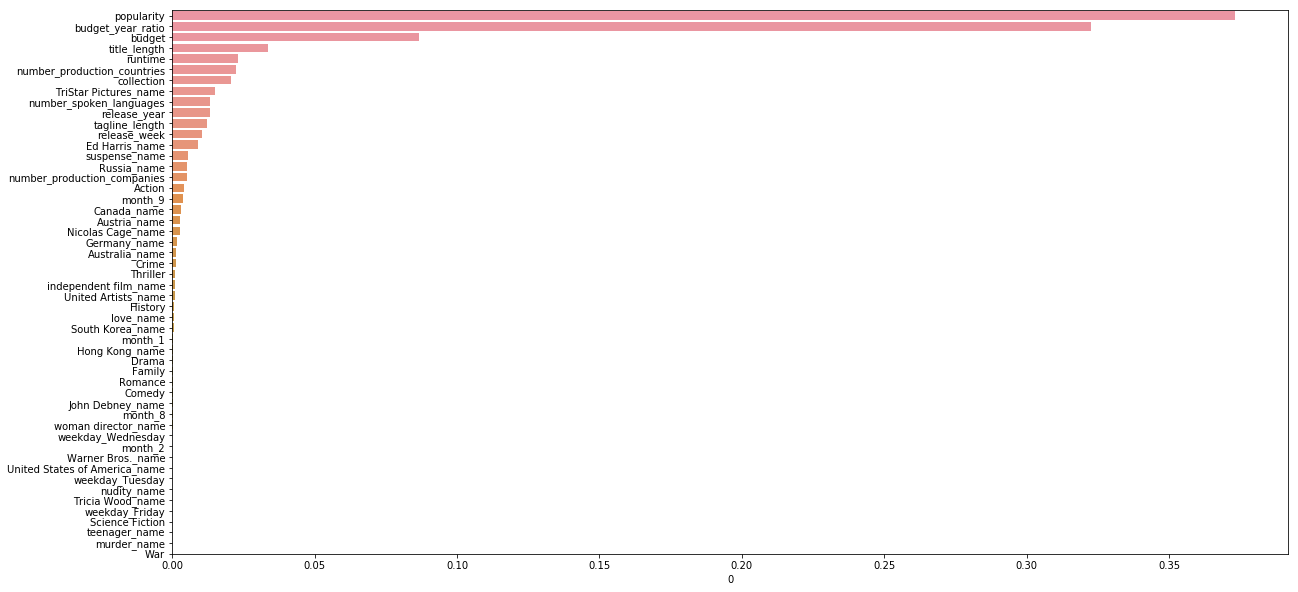

In [140]:
# Plot the feature importance of the AdaBoost model
plt.figure(figsize=(20,10))
sb.barplot(importances_ada_df[0], importances_ada_df.index)
plt.ylim(bottom=50);


Based on the above analysis of feature importance, the most important features are:

1. popularity
2. budget_year_ratio
3. budget
4. title_length
5. runtime

##### XGBoost

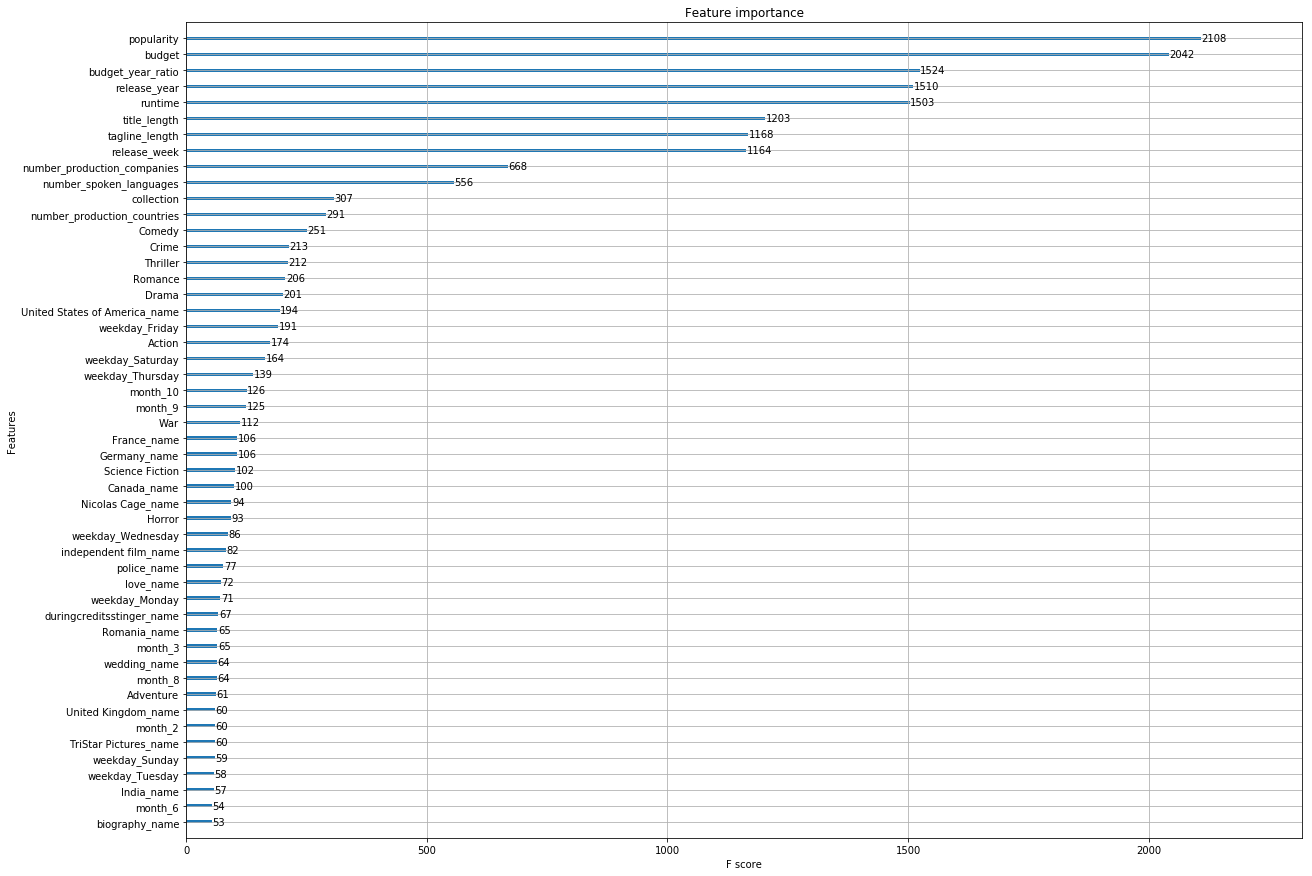

In [126]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(20, 15))
xgb.plot_importance(clf_xgb, max_num_features=50, importance_type='weight', ax=ax);


Based on the above analysis of feature importance, the most important features are:

1. popularity
2. budget
3. budget_year_ratio
4. release_year
5. runtime

##### LightGBM

I played around with GridSearchCV to optimize the LGBM model, however, the default parameters gave me the best results. I plotted the most important features below.

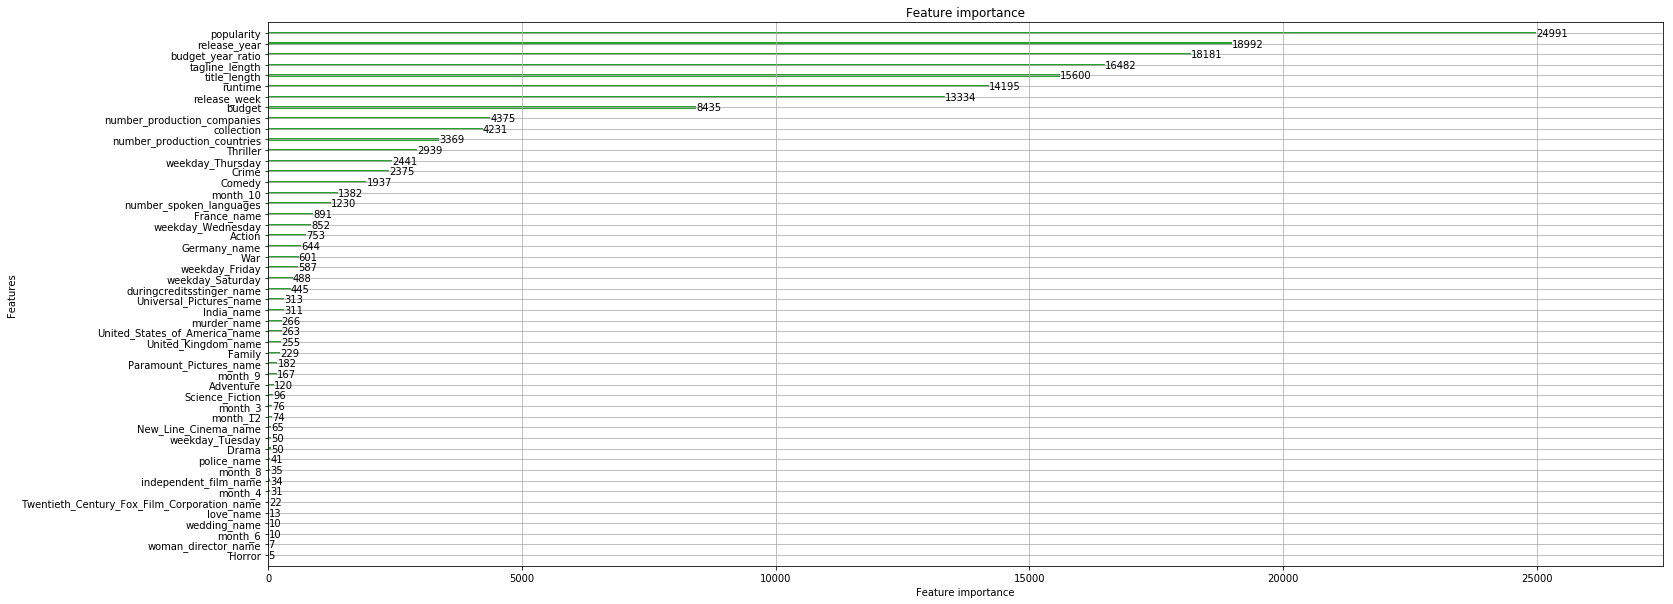

In [127]:
# Plot the feature importance of the LightGBM model
fig, ax = plt.subplots(figsize=(25,10))
lgb.plot_importance(clf_lgb, ax=ax, color=green, max_num_features=50);


Based on the above analysis of feature importance, the most important features are:
1. popularity
2. budget_year_ratio
3. release_year
4. runtime
5. title_length

__Discussion of results__

I saw in the data exploration that popularity is positively correlated to revenue, so the importance of popularity is of little surprise. For budget, there was also a positive correlation and I expected this feature to be very important. I used budget_year_ratio to account for the inflation that occured over time. As the release year increased, the revenue increased as well which can also be seen in the earlier data exploration. I am surprised that runtime is actually of such importance as well as the title length.

#### 5.3. Making predictions on test data set

I want to answer the question:

**Which movies will be failures and which will be successes**

In order to get an answer, I first have to define what I mean by failure and by success. I found a [research paper](https://www.researchgate.net/publication/313455341_Predicting_Movie_Box_Office_Profitability_A_Neural_Network_Approach) that was also predicting movie revenue and they defines success as making a profit. And profit was defined as:

Profit = (1/2) * Revenue - Budget

I will first predict the revenues of the movies and then categorize them as either failures or successes based on the above definition. I will will then make a determination on how good my model can predict this binary case.


In [128]:
def flop_success_preds(title_df, test_df, y_pred, train_set=True, label_df=[]):
    '''
    Function to determine flops and successes for dataset
    Args: title_df = dataframe; cleaned dataframe that still contains titles
          test_df = dataframe; dataframe containing test data or other data that should be predicted
          y_pred = numpy array; predicted revenue values
          train_set = boolean; default value: True
          label_df = dataframe; default value is an empty list; can take in dataframe containing revenue variable
    Returns: flop_success_df = dataframe
    '''
    
    # Create dataframe with absolute budget variable and titles
    title_budget_df = title_df[['budget', 'title']]
    
    # Keep only the rows that are in the test_df dataset
    title_budget_df = title_budget_df.loc[test_df.index,:]

    if train_set:
        # Add the actual revenue figures to the dataframe
        title_budget_df = title_budget_df.join(label_df, how='left')
        
    # Add predictions on test_df data set 
    y_pred = pd.DataFrame(np.expm1(scaler_revenue.inverse_transform((y_pred).reshape(-1,1))).astype('int32'), columns=['preds'])

    # Reset index of title_budget_df so that it can be joined with y_pred
    title_budget_df = title_budget_df.reset_index()

    # Add the test_df predictions and actual revenue figures to the new dataframe
    flop_success_df = title_budget_df.join(y_pred)

    # Add profit column for predictions
    flop_success_df['profit_preds'] = (1/2) * flop_success_df['preds'] - flop_success_df['budget']

    # Add columns with boolean values Yes/No depending on whether the movie made a profit
    flop_success_df['cat_profit_preds'] = flop_success_df['profit_preds'].apply(lambda x: 'Yes' if x > 0 else 'No')

    if train_set:
        # Add profit column for actual revenue figures
        flop_success_df['profit_actual'] = (1/2) * flop_success_df['revenue'] - flop_success_df['budget']
        # Add columns with boolean values Yes/No depending on whether the movie made a profit
        flop_success_df['cat_profit_actual'] = flop_success_df['profit_actual'].apply(lambda x: 'Yes' if x > 0 else 'No')
    
    return flop_success_df
    
    

In [129]:
def plot_confusion_matrix(y_test, y_pred):
    '''
    Function to plot a confusion matrix and the accuracy of the predictions
    Args: y_test = numpy array or pandas series; categorical values of actual flop/success
          y_pred = numpy array or pandas series; categorical values of predicted flop/success
    Returns: None
    '''
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred) 

    # Convert confusion matrix to dataframe
    cm_df = pd.DataFrame(cm, index = ['Success', 'Flop'], columns = ['Success', 'Flop'])

    # Plot the confuction matrix
    plt.figure(figsize=(7, 6))
    sb.heatmap(cm_df, annot=True, fmt='d')

    plt.title('Flop and Success Predictions \nAccuracy:{0:.3f}'.format(accuracy_score(y_test,
                                                                                      y_pred)))
    plt.ylabel('True label')
    plt.xlabel('Predicted label');
    
      

##### Train set flop/success predictions

In [130]:
# Get dataframe containing predictions on flops and successes of movies
flop_success_X_train = flop_success_preds(train_features_with_title, 
                                          X_train, 
                                          y_pred_train_xgb, 
                                          train_set=True, 
                                          label_df=train_revenue)
flop_success_X_train


,index,budget,title,revenue,preds,profit_preds,cat_profit_preds,profit_actual,cat_profit_actual
0,552,200000000,World War Z,531865000,515946624,57973312.0,Yes,65932500.0,Yes
1,765,12000000,District B13,9584131,15239306,-4380347.0,No,-7207934.5,No
2,479,54000000,V for Vendetta,132511035,132212448,12106224.0,Yes,12255517.5,Yes
3,256,75000000,Soldier,14567883,15688634,-67155683.0,No,-67716058.5,No
4,1488,134000,Cat People,4000000,3061400,1396700.0,Yes,1866000.0,Yes
5,440,700000,The Tracey Fragments,31576,99261,-650369.5,No,-684212.0,No
6,873,5000000,"War, Inc.",1296184,1600387,-4199806.5,No,-4351908.0,No
7,1825,12500000,The Ides of March,75993061,26905452,952726.0,Yes,25496530.5,Yes
8,2098,3512454,Camille Claudel 1915,115860,262954,-3380977.0,No,-3454524.0,No
9,1709,30000000,The Frighteners,29359216,77967192,8983596.0,Yes,-15320392.0,No


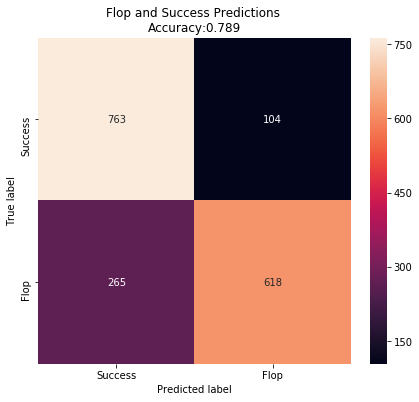

In [131]:
# Add confusion matrix for X_train dataset
plot_confusion_matrix(flop_success_X_train['cat_profit_actual'], flop_success_X_train['cat_profit_preds'])


###### Cross-validation set flop/success predictions


In [132]:
pd.options.display.max_rows = 100

In [133]:
# Get dataframe containing predictions on flops and successes of movies
flop_success_X_cross = flop_success_preds(train_features_with_title, X_cross, y_pred_xgb, train_set=True, label_df=train_revenue)
flop_success_X_cross


,index,budget,title,revenue,preds,profit_preds,cat_profit_preds,profit_actual,cat_profit_actual
0,571,13000000,"Dude, Where’s My Car?",73180723,41313004,7656502.0,Yes,23590361.5,Yes
1,1317,135000000,Miami Vice,163794509,192569888,-38715056.0,No,-53102745.5,No
2,2116,75000000,Backdraft,152368585,169605232,9802616.0,Yes,1184292.5,Yes
3,1563,10000000,Reno 911!: Miami,20342161,6437509,-6781245.5,No,171080.5,Yes
4,1146,30000000,Highlander II: The Quickening,15556340,68734448,4367224.0,Yes,-22221830.0,No
5,1054,5000000,The Irony of Fate. The Sequel,55635037,5389903,-2305048.5,No,22817518.5,Yes
6,416,80000000,Edge of Darkness,74901339,90813448,-34593276.0,No,-42549330.5,No
7,1397,175000000,Evan Almighty,173000000,354696576,2348288.0,Yes,-88500000.0,No
8,985,23000000,Marvin's Room,12803305,17899084,-14050458.0,No,-16598347.5,No
9,514,90000000,The Expendables 3,206172544,207017824,13508912.0,Yes,13086272.0,Yes


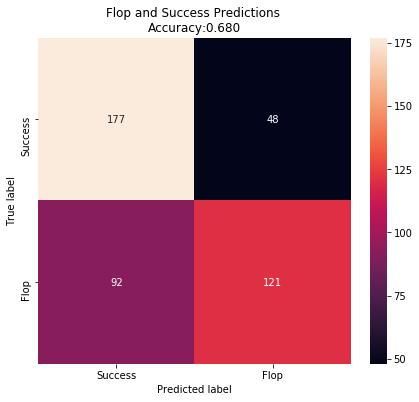

In [134]:
# Add confusion matrix for the X_cross dataset
plot_confusion_matrix(flop_success_X_cross['cat_profit_actual'], flop_success_X_cross['cat_profit_preds'])


###### Test set flop/success predictions

In [135]:
# Make prediction on test data set
actual_y_test = clf_lgb.predict(test_features_df)

flop_success_test = flop_success_preds(test_title, test_features_df, actual_y_test, train_set=False)
flop_success_test.sort_values('preds', ascending=False)


,index,budget,title,preds,profit_preds,cat_profit_preds
2282,2282,250000000,Batman v Superman: Dawn of Justice,709937979,104968989.5,Yes
2841,2841,178000000,X-Men: Apocalypse,694269458,169134729.0,Yes
271,271,200000000,The Amazing Spider-Man 2,693223055,146611527.5,Yes
717,717,215000000,The Amazing Spider-Man,682786378,126393189.0,Yes
701,701,210000000,Transformers: Age of Extinction,666829691,123414845.5,Yes
2618,2618,130000000,Ant-Man,645405784,192702892.0,Yes
1146,1146,250000000,Captain America: Civil War,636932108,68466054.0,Yes
2803,2803,250000000,The Hobbit: The Battle of the Five Armies,634719553,67359776.5,Yes
141,141,140000000,Iron Man,633072994,176536497.0,Yes
326,326,180000000,Pacific Rim,624667384,132333692.0,Yes


In [136]:
# Do samples on certain movies
flop_success_test[flop_success_test['title'].str.contains('Thor', na=False)]


,index,budget,title,preds,profit_preds,cat_profit_preds
369,369,170000000,Thor: The Dark World,555622531,107811265.5,Yes
2075,2075,150000000,Thor,590943744,145471872.0,Yes


__Discussion of results__

Calculating the actual profit and the predicted profits for both the X_train and the X_cross data set yields an accuracy of 78.9% for the training data and 68% for the cross-validation data.

43.2% of movies that flopped are incorrectly predicted as successful movies, while 21.3% of successful movies are incorrectly predicted to be flops. This indicates that the model has a tendency to predict higher than actual values.

The accuracy is rather low because the model was not optimized for the binary case but for prediction the absolute revenue figures.

### Conclusion

#### 1. Which variables are particularly predictive of revenue?

Based on the above analysis, the following features are most predictive of revenue __according to all models__:
* popularity
* budget_year_ratio
* runtime

Moreover, the __LightGBM__ model also shows that these features are especially important:
* release_year
* tagline_length
* title_lenght
* release_week
* budget
* collection


#### 2. How well can the model predict flopped and successful movies?

The accuracy of the predicted labels 'flop' and 'success' only reaches a __level of 68%__. However, considering the limited number of samples used in the training phase and the general difficulty to determine the right features out of the vast amount of data available and at the same time the data inconsistency.

I was surprised how difficult it was to predict the revenue and how large the root mean squared error still remained. Because it was difficult for me to grasp the meaningfulness of the RMSE metric, I added the profit variable and tried to get a better understand of how the model can classify movies. It just showed how difficult

### Limitations and further improvements

There are a number of limitations that need to be considered when judging the robustness and accuracy of these models:
* The training dataset is relatively small with only 2188 samples (excluding samples that were removed due to missing values). With a larger training set, the predictions may be better.
* Feature selection. Adding other variables that contain user ratings, critics scores, social media content or even [data from recommendation systems such as Netflix](https://medium.com/r/?url=https%3A%2F%2Fwww.researchgate.net%2Fpublication%2F313455341_Predicting_Movie_Box_Office_Profitability_A_Neural_Network_Approach) could prove valuable when trying to improve accuracy.
* The implemented models use linear regression as a basis for their estimations because the target variable is a numeric value. Linear regression can lead to large mean squared errors if the data is relatively scattered.
* The accuracy I am calculating for the binary cases of 'flop' or 'success' is only based on the regressions that are optimized for the numeric revenue values. Most likely the accuracy could be improved if the learner would be a Classifier and was optimizing the model for the binary label cases. Deep Learning algorithms would probably lead to better predictions.

